In [2]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# system related and data input controls
import os
import datetime

# data manipulation and visualization
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format # number format
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import yfinance as yf

# Modeling algorithms
# General
import statsmodels.api as sm
from scipy import stats
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages
tf.get_logger().warning('test')
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Activation, Flatten, Reshape
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, TimeDistributed, SimpleRNN
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.utils import plot_model

# model selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# evaluation metrics
from sklearn import metrics

# for regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
# for classification
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from tqdm import tqdm


In [3]:
# 실제 Y와 예측치 시각화
def plot_prediction(Y_true_pred):
    plt.figure(figsize=(16, 8))
    plt.plot(Y_true_pred, linewidth=5, label=Y_true_pred.columns)
    plt.xticks(fontsize=25, rotation=0)
    plt.yticks(fontsize=25)
    plt.xlabel('Index', fontname='serif', fontsize=28)
    plt.legend(fontsize=20)
    plt.grid()
    plt.show()

In [4]:
def error_analysis(X_Data, Y_Pred, Residual, graph_on=False):
    if graph_on == True:
        ##### 시각화
        # 잔차의 정규본포성 확인
        # sns.displot(Residual, norm_hist='True', fit=stats.norm)
        sns.displot(Residual, kind='hist')
        plt.show()

        # 잔차의 등분산성 확인
        temp = pd.concat([Y_Pred, Residual.reset_index().iloc[:,[1]]], axis=1)
        sns.scatterplot(x='Pred', y='Error', data=temp)
        plt.show()
        
        # 잔차의 자기상관성 확인
        sm.graphics.tsa.plot_acf(Residual, lags=50, use_vlines=True)
        plt.show()

    ##### 통계량
    # 정규분포
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Residual)], 
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # 등분산성
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Residual, X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], 
                                      columns=['Test Statistics', 'p-value', 'Alternative']).T
    
    # 자기상관
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Residual, lags=[10,50]).iloc[:,0]),
                             pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Residual, lags=[10,50]).iloc[:,1])], axis=1).T
    Autocorrelation.index = ['Test Statistics', 'p-value']
    Autocorrelation.columns = ['Autocorr(lag10)', 'Autocorr(lag50)']
    
    Error_Analysis = pd.concat([Normality, Heteroscedasticity, Autocorrelation], join='outer', axis=1)
    
    return Error_Analysis

In [5]:
# 검증 함수화
def evaluation_reg(Y_real, Y_pred):
    MAE = mean_absolute_error(Y_real, Y_pred)
    MSE = mean_squared_error(Y_real, Y_pred)
    MAPE = mean_absolute_percentage_error(Y_real, Y_pred)
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    
    return Score

In [6]:
# Train & Test 모두의 검증 함수화
def evaluation_reg_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te):
    Score_tr = evaluation_reg(Y_real_tr, Y_pred_tr)
    Score_te = evaluation_reg(Y_real_te, Y_pred_te)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']

    return Score_trte

In [7]:
df_apple = pd.DataFrame()

In [8]:
# get Apple stock data
apple = yf.Ticker("AAPL")
apple_df = apple.history(period="max")
apple_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-06-16 00:00:00-04:00,186.73,186.99,184.27,184.92,101235600,0.00,0.00
2023-06-20 00:00:00-04:00,184.41,186.10,184.41,185.01,49799100,0.00,0.00
2023-06-21 00:00:00-04:00,184.90,185.41,182.59,183.96,49515700,0.00,0.00
2023-06-22 00:00:00-04:00,183.74,187.05,183.67,187.00,51245300,0.00,0.00
2023-06-23 00:00:00-04:00,185.55,187.56,185.01,186.68,50349169,0.00,0.00


In [9]:
apple_df.index = pd.to_datetime(apple_df.index).strftime('%Y-%m-%d')
df_apple['price'] = apple_df['Close']
df_apple

,price
Date,
1980-12-12,0.10
1980-12-15,0.09
1980-12-16,0.09
1980-12-17,0.09
1980-12-18,0.09
...,...
2023-06-16,184.92
2023-06-20,185.01
2023-06-21,183.96


## Exchange rate (ESD-EUR)

In [10]:
# get exchange rate
eur_usd= yf.Ticker("EURUSD=X")
eur_usd_df = eur_usd.history(period="max")
eur_usd_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2003-12-01 00:00:00+00:00,1.20,1.20,1.19,1.20,0,0.00,0.00
2003-12-02 00:00:00+00:00,1.20,1.21,1.19,1.21,0,0.00,0.00
2003-12-03 00:00:00+00:00,1.21,1.21,1.21,1.21,0,0.00,0.00
2003-12-04 00:00:00+00:00,1.21,1.21,1.20,1.21,0,0.00,0.00
2003-12-05 00:00:00+00:00,1.21,1.22,1.21,1.22,0,0.00,0.00
...,...,...,...,...,...,...,...
2023-06-19 00:00:00+01:00,1.09,1.09,1.09,1.09,0,0.00,0.00
2023-06-20 00:00:00+01:00,1.09,1.09,1.09,1.09,0,0.00,0.00
2023-06-21 00:00:00+01:00,1.09,1.10,1.09,1.09,0,0.00,0.00


In [11]:
eur_usd_df.index = pd.to_datetime(eur_usd_df.index).strftime('%Y-%m-%d')
df_apple['eur_usd'] = eur_usd_df['Close']
df_apple

,price,eur_usd
Date,,
1980-12-12,0.10,NaN
1980-12-15,0.09,NaN
1980-12-16,0.09,NaN
1980-12-17,0.09,NaN
1980-12-18,0.09,NaN
...,...,...
2023-06-16,184.92,1.09
2023-06-20,185.01,1.09
2023-06-21,183.96,1.09


## Exchange rate (usd/cny)

In [12]:
cny_usd = yf.Ticker("CNYUSD=X")
cny_usd_df = cny_usd.history(period="max")
cny_usd_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2001-06-25 00:00:00+01:00,0.12,0.12,0.12,0.12,0,0.00,0.00
2001-06-26 00:00:00+01:00,0.12,0.12,0.12,0.12,0,0.00,0.00
2001-07-02 00:00:00+01:00,0.12,0.12,0.12,0.12,0,0.00,0.00
2001-07-09 00:00:00+01:00,0.12,0.12,0.12,0.12,0,0.00,0.00
2001-07-11 00:00:00+01:00,0.12,0.12,0.12,0.12,0,0.00,0.00
...,...,...,...,...,...,...,...
2023-06-20 00:00:00+01:00,0.14,0.14,0.14,0.14,0,0.00,0.00
2023-06-21 00:00:00+01:00,0.14,0.14,0.14,0.14,0,0.00,0.00
2023-06-22 00:00:00+01:00,0.14,0.14,0.14,0.14,0,0.00,0.00


In [13]:
cny_usd_df.index = pd.to_datetime(cny_usd_df.index).strftime('%Y-%m-%d')
df_apple['cny_usd'] = cny_usd_df['Close']
df_apple

,price,eur_usd,cny_usd
Date,,,
1980-12-12,0.10,NaN,NaN
1980-12-15,0.09,NaN,NaN
1980-12-16,0.09,NaN,NaN
1980-12-17,0.09,NaN,NaN
1980-12-18,0.09,NaN,NaN
...,...,...,...
2023-06-16,184.92,1.09,0.14
2023-06-20,185.01,1.09,0.14
2023-06-21,183.96,1.09,0.14


In [14]:
def get_data(ticker_code, index_name, peroiod="max"):
    # get the data
    data = yf.Ticker(ticker_code)
    data = data.history(period=peroiod)
    data.insert(0, "code", ticker_code)
    data.insert(0, "index_name", index_name)

    ## change column name into small letters
    data = data.rename(columns={"Date": "date", "Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume", "Dividends": "dividends", "Stock Splits": "stock_splits"})
    data.index.name = "date"

    ## change data format
    data.index = pd.to_datetime(data.index, format='%d-%m-%Y')
    data.index = data.index.strftime('%Y-%m-%d')
    data["open"] = data["open"].astype(float)
    data["high"] = data["high"].astype(float)
    data["low"] = data["low"].astype(float)
    data["close"] = data["close"].astype(float)
    data["volume"] = data["volume"].astype(int)
    data["dividends"] = data["dividends"].astype(float)
    data["stock_splits"] = data["stock_splits"].astype(float)

    ## mange missing data
    data = data.replace([np.inf, -np.inf], np.nan)
    data = data.fillna(0)
    data = data.round(2)

    return data

## Dow jones

In [15]:
dowjones = yf.Ticker("^DJI")
dowjones_df = dowjones.history(period="max")
dowjones_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1992-01-02 00:00:00-05:00,"3,152.10","3,172.63","3,139.31","3,172.40",23550000,0.00,0.00
1992-01-03 00:00:00-05:00,"3,172.40","3,210.64","3,165.92","3,201.50",23620000,0.00,0.00
1992-01-06 00:00:00-05:00,"3,201.50","3,213.33","3,191.86","3,200.10",27280000,0.00,0.00
1992-01-07 00:00:00-05:00,"3,200.10","3,210.20","3,184.48","3,204.80",25510000,0.00,0.00
1992-01-08 00:00:00-05:00,"3,204.80","3,229.20","3,185.82","3,203.90",29040000,0.00,0.00
...,...,...,...,...,...,...,...
2023-06-16 00:00:00-04:00,"34,464.02","34,588.68","34,285.69","34,299.12",595230000,0.00,0.00
2023-06-20 00:00:00-04:00,"34,206.66","34,206.66","33,915.93","34,053.87",334810000,0.00,0.00
2023-06-21 00:00:00-04:00,"33,990.56","34,097.93","33,876.17","33,951.52",323690000,0.00,0.00


In [16]:
dowjones_df.index = pd.to_datetime(dowjones_df.index).strftime('%Y-%m-%d')
df_apple['dowjones'] = dowjones_df['Close']
df_apple

,price,eur_usd,cny_usd,dowjones
Date,,,,
1980-12-12,0.10,NaN,NaN,NaN
1980-12-15,0.09,NaN,NaN,NaN
1980-12-16,0.09,NaN,NaN,NaN
1980-12-17,0.09,NaN,NaN,NaN
1980-12-18,0.09,NaN,NaN,NaN
...,...,...,...,...
2023-06-16,184.92,1.09,0.14,"34,299.12"
2023-06-20,185.01,1.09,0.14,"34,053.87"
2023-06-21,183.96,1.09,0.14,"33,951.52"


## Sector ETF

In [17]:
# us stock sector indexes code: XLK, XLV, XLY, XLP, XLE, XLF, XLI, XLB, XLRE, XLU

us_sector_indexes = ['XLK', 'XLV', 'XLY', 'XLP', 'XLE', 'XLF', 'XLI', 'XLB', 'XLRE', 'XLU']

for index_code in us_sector_indexes:
    index_name = index_code
    index_df = get_data(index_code, index_name)
    df_apple[index_name] = index_df['close']

df_apple

,price,eur_usd,cny_usd,dowjones,XLK,XLV,XLY,XLP,XLE,XLF,XLI,XLB,XLRE,XLU
Date,,,,,,,,,,,,,,
1980-12-12,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-15,0.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-16,0.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-17,0.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-18,0.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-16,184.92,1.09,0.14,"34,299.12",172.83,131.67,166.05,74.14,80.15,33.43,105.03,81.35,37.33,66.76
2023-06-20,185.01,1.09,0.14,"34,053.87",171.66,131.52,167.29,73.58,78.36,33.18,104.25,80.25,36.93,65.98
2023-06-21,183.96,1.09,0.14,"33,951.52",169.12,131.54,165.28,73.84,78.98,33.14,104.83,80.51,36.77,66.51


# treasury bond

In [18]:
# t_bond = yf.Ticker("^IRX")
# t_bond_df = dowjones.history(period="max")
# t_bond_df

In [19]:
t_bills_df = pd.read_csv('./data/^IRX.csv')
t_bills_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1960-01-04,4.52,4.52,4.52,4.52,4.52,0.00
1,1960-01-05,4.55,4.55,4.55,4.55,4.55,0.00
2,1960-01-06,4.68,4.68,4.68,4.68,4.68,0.00
3,1960-01-07,4.63,4.63,4.63,4.63,4.63,0.00
4,1960-01-08,4.59,4.59,4.59,4.59,4.59,0.00
...,...,...,...,...,...,...,...
19720,2023-06-12,5.10,5.11,5.08,5.09,5.09,0.00
19721,2023-06-13,5.13,5.13,5.04,5.10,5.10,0.00
19722,2023-06-14,5.09,5.11,5.00,5.08,5.08,0.00
19723,2023-06-15,5.07,5.08,5.05,5.05,5.05,0.00


In [20]:
t_bills_df.set_index(keys=['Date'], inplace=True, drop=True)

In [21]:
df_apple['t_bills'] = t_bills_df['Close']

In [22]:
df_apple.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10722 entries, 1980-12-12 to 2023-06-23
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     10722 non-null  float64
 1   eur_usd   4895 non-null   float64
 2   cny_usd   5293 non-null   float64
 3   dowjones  7928 non-null   float64
 4   XLK       6165 non-null   float64
 5   XLV       6165 non-null   float64
 6   XLY       6165 non-null   float64
 7   XLP       6165 non-null   float64
 8   XLE       6165 non-null   float64
 9   XLF       6165 non-null   float64
 10  XLI       6165 non-null   float64
 11  XLB       6165 non-null   float64
 12  XLRE      1940 non-null   float64
 13  XLU       6165 non-null   float64
 14  t_bills   10656 non-null  float64
dtypes: float64(15)
memory usage: 1.3+ MB


In [23]:
df_apple.dropna(inplace=True)
df_apple

,price,eur_usd,cny_usd,dowjones,XLK,XLV,XLY,XLP,XLE,XLF,XLI,XLB,XLRE,XLU,t_bills
Date,,,,,,,,,,,,,,,
2015-10-08,24.88,1.12,0.16,"17,050.75",37.36,59.89,70.86,40.19,49.75,16.29,46.00,37.72,23.11,34.19,0.00
2015-10-09,25.48,1.13,0.16,"17,084.49",37.52,60.16,70.94,40.28,49.43,16.19,46.15,37.70,23.07,34.03,0.00
2015-10-12,25.36,1.14,0.16,"17,131.86",37.57,60.32,71.28,40.38,48.79,16.20,46.16,37.37,23.22,34.33,0.01
2015-10-13,25.40,1.14,0.16,"17,081.89",37.49,59.56,70.89,40.14,48.28,16.08,45.67,37.23,23.07,34.26,0.01
2015-10-14,25.04,1.14,0.16,"16,924.75",37.41,59.45,70.17,39.67,48.69,15.95,45.17,37.53,23.07,34.25,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-12,183.79,1.08,0.14,"34,066.33",169.27,130.35,163.64,72.58,79.85,32.99,102.72,78.97,36.75,65.74,5.09
2023-06-13,183.31,1.08,0.14,"34,212.12",170.29,131.01,165.34,72.87,80.22,33.19,103.91,80.80,37.01,65.73,5.10
2023-06-14,183.95,1.08,0.14,"33,979.33",172.05,129.67,165.22,73.32,79.40,33.06,103.64,80.47,37.21,65.69,5.08


In [24]:
# start_date
# df_apple = df_apple.loc[df_apple.index >= '2020-01-01']
# df_apple

# Data preprocessing

In [25]:
# # y data to return
# df_apple['return'] = df_apple['price'].pct_change()
# df_apple.dropna(inplace=True)
# df_apple['return']

In [26]:
df_apple['MA20'] = df_apple['price'].rolling(window=20).mean()
df_apple['MA60'] = df_apple['price'].rolling(window=60).mean()
df_apple['MA120'] = df_apple['price'].rolling(window=120).mean()
df_apple['MA20'] = df_apple['MA20'].shift(1)
df_apple['MA60'] = df_apple['MA60'].shift(1)
df_apple['MA120'] = df_apple['MA120'].shift(1)
df_apple.dropna(inplace=True)

In [27]:
# df_apple['price'] = df_apple['price'].shift()
# df_apple.dropna(inplace=True)

In [28]:
# train test split
df_apple_train = df_apple.loc[df_apple.index <= '2022-12-31', :]
df_apple_test = df_apple.loc[df_apple.index > '2022-12-31', :]
print(df_apple_train.shape, df_apple_test.shape)

(1695, 18) (115, 18)


In [29]:
# split into X and y
Y_colname = ['MA20']
X_col_remove = ['price', 'MA20', 'MA60', 'MA120']
X_colnames = df_apple.columns.drop(Y_colname).tolist()

Y_train = df_apple_train[Y_colname]
X_train = df_apple_train[X_colnames]
Y_test = df_apple_test[Y_colname]
X_test = df_apple_test[X_colnames]

# 데이터의 갯수와 크기 확인
print('---------------train----------------')
print('X: ', X_train.shape)
print('Y: ', Y_train.shape)
display(X_train.describe().T)
print('----------------test----------------')
print('X: ', X_test.shape)
print('Y: ', Y_test.shape)
display(X_test.describe().T)

---------------train----------------
X:  (1695, 17)
Y:  (1695, 1)


,count,mean,std,min,25%,50%,75%,max
price,"1,695.00",79.58,49.47,20.85,38.55,53.28,129.98,180.43
eur_usd,"1,695.00",1.13,0.06,0.96,1.10,1.13,1.18,1.25
cny_usd,"1,695.00",0.15,0.01,0.14,0.14,0.15,0.15,0.16
dowjones,"1,695.00","26,786.83","5,284.90","17,140.24","23,337.85","26,124.57","31,303.35","36,799.65"
XLK,"1,695.00",90.52,38.76,38.04,59.48,76.33,127.64,174.18
XLV,"1,695.00",93.68,23.50,58.95,74.83,85.72,117.55,139.96
XLY,"1,695.00",121.39,36.46,69.05,90.09,113.48,150.81,208.23
XLP,"1,695.00",55.49,10.26,41.94,46.49,52.99,65.62,77.96
XLE,"1,695.00",51.75,12.69,20.21,46.93,50.79,55.70,91.35
XLF,"1,695.00",26.39,6.20,15.18,22.07,24.98,31.57,40.19


----------------test----------------
X:  (115, 17)
Y:  (115, 1)


,count,mean,std,min,25%,50%,75%,max
price,115.00,158.59,15.01,124.66,148.95,159.06,171.55,186.01
eur_usd,115.00,1.08,0.01,1.05,1.07,1.08,1.09,1.11
cny_usd,115.00,0.14,0.00,0.14,0.14,0.15,0.15,0.15
dowjones,115.00,"33,388.88",622.16,"31,819.14","33,043.67","33,531.33","33,876.09","34,408.06"
XLK,115.00,145.41,11.74,120.66,137.11,144.53,150.66,174.26
XLV,115.00,130.43,2.89,123.16,128.14,131.09,132.84,135.10
XLY,115.00,146.31,7.29,127.74,142.37,146.26,149.50,166.30
XLP,115.00,73.44,1.74,70.27,72.10,72.91,74.83,76.95
XLE,115.00,82.69,3.83,75.51,79.44,83.05,85.75,91.34
XLF,115.00,33.51,1.77,30.69,31.97,33.00,35.31,36.65


In [30]:
# scaling
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


print('---------------train----------------')
print('normalized X: ', X_train.shape, X_train.min(), X_train.max())
print('----------------test----------------')
print('normalized X: ', X_test.shape, X_test.min(), X_test.max())

---------------train----------------
normalized X:  (1695, 17) 0.0 1.0
----------------test----------------
normalized X:  (115, 17) 0.11588330632090837 1.2048165653837497


In [31]:
# data backup
X_trprep2D, X_teprep2D = X_train.copy(), X_test.copy()
Y_trprep2D, Y_teprep2D = Y_train.copy(), Y_test.copy()

# MLP

In [32]:
# HYPERPARAMETER
tf.random.set_seed(1)
KERNEL_SIZE = 3
STRIDE = 1
POOL_SIZE = 2
POOL_STRIDE = 2
PADDING = 'same'
HIDDEN_ACTIVATION = 'relu'
OUTPUT_ACTIVATION = 'linear'
REGULARIZER = regularizers.l2(0.01)
DROPOUT_RATIO = 0.25
LOSS = 'mse'
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['mse']
BATCH_SIZE = 64
EPOCHS = 100
VERBOSE = 0
#################
EARLYSTOP_PATIENT = 20
MONITOR = 'val_loss'
FILENAME = os.path.join(os.getcwd(),'Model','apple_MLP.h5')
CALLBACK = [callbacks.EarlyStopping(monitor=MONITOR, mode='min', 
                                    patience=EARLYSTOP_PATIENT, verbose=1),
            tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
            callbacks.ModelCheckpoint(monitor=MONITOR, mode='min', save_best_only=True, 
                                      filepath=FILENAME)]
################

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-06-24 09:32:04.754554: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-24 09:32:04.754905: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


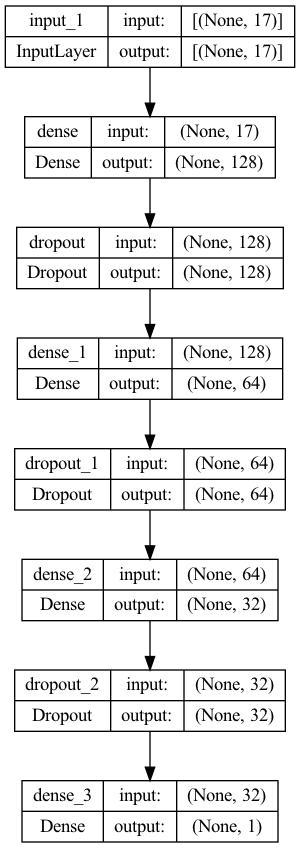

In [33]:
# buiding network
inputs = Input(shape=(X_train.shape[1],))
hiddens = Dense(128, activation=HIDDEN_ACTIVATION, kernel_regularizer=REGULARIZER)(inputs)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Dense(64, activation=HIDDEN_ACTIVATION, kernel_regularizer=REGULARIZER)(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Dense(32, activation=HIDDEN_ACTIVATION, kernel_regularizer=REGULARIZER)(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
outputs = Dense(1, activation=OUTPUT_ACTIVATION)(hiddens)
model = Model(inputs, outputs)
plot_model(model, show_shapes=True)

Training:   0%|           0/100 ETA: ?s,  ?epochs/s2023-06-24 09:32:07.192891: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-24 09:32:07.586790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-24 09:32:13.472227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Training: 100%|██████████ 100/100 ETA: 00:00s,   2.28epochs/s


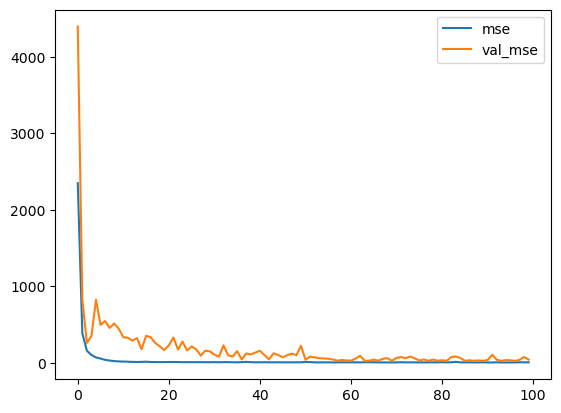

In [34]:
# fit model
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
model_fit = model.fit(X_train, Y_train, validation_split=0.2,
                    batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE,
                    callbacks=CALLBACK)
plt.plot(pd.DataFrame(model_fit.history[METRICS[0]]), label='train')
plt.plot(pd.DataFrame(model_fit.history['val_'+METRICS[0]]), label='test')
plt.legend([METRICS[0], 'val_'+METRICS[0]])
plt.show()

21/53 [==========>...................] - ETA: 0s

2023-06-24 09:32:51.377507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 11ms/step


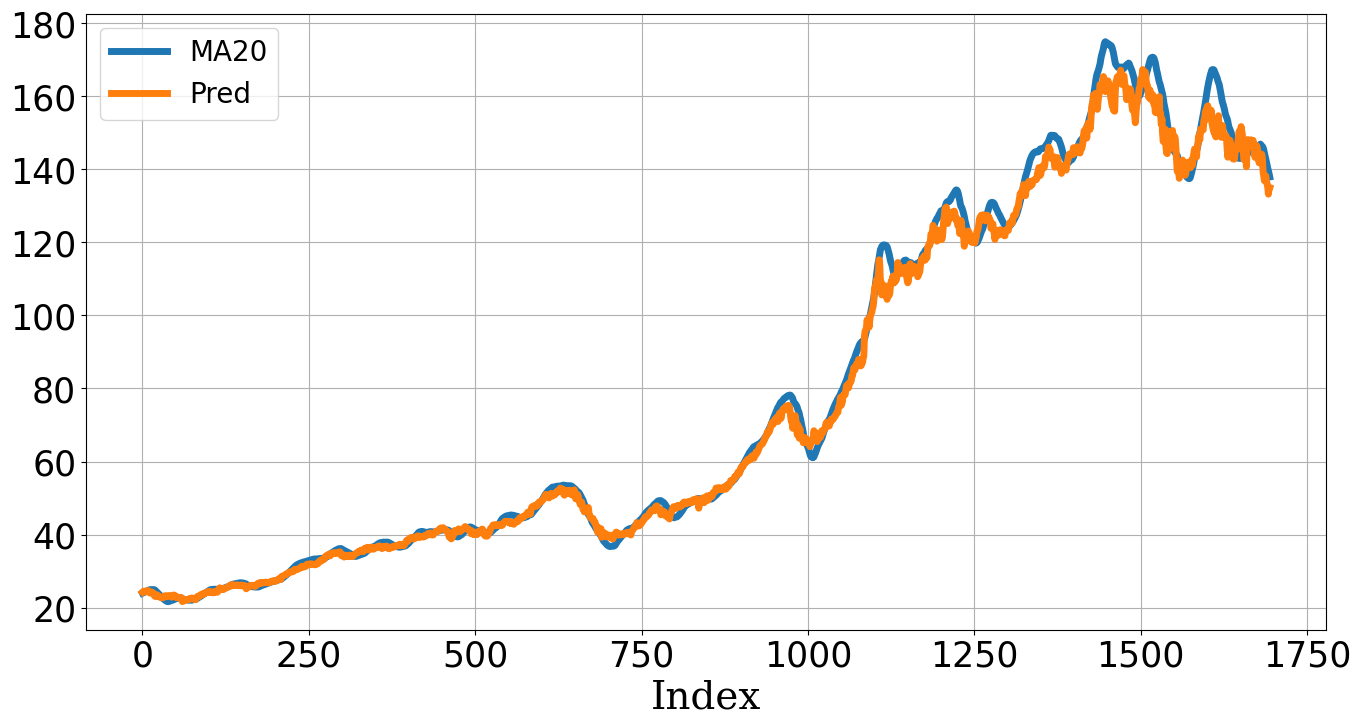

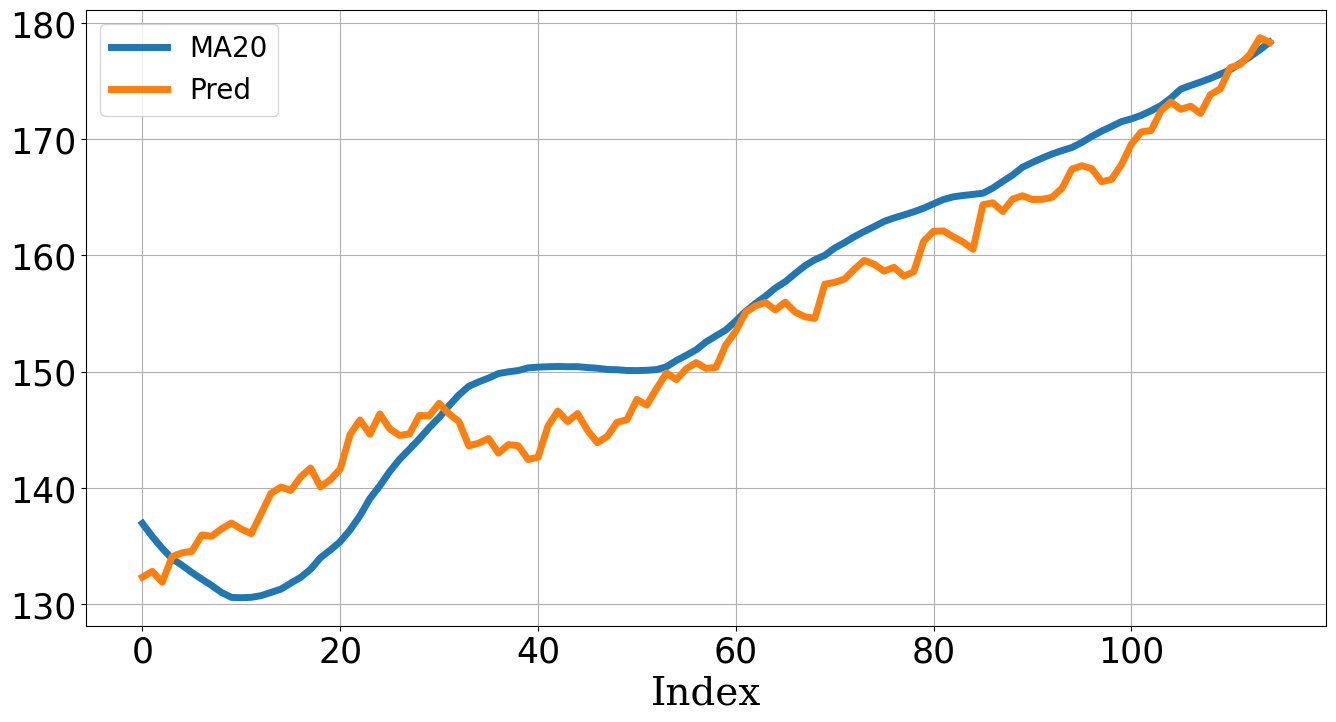

In [35]:
## Predict
Y_train_pred = pd.DataFrame(model.predict(X_train), index=Y_train.index, columns=['Pred'])
Y_test_pred = pd.DataFrame(model.predict(X_test), index=Y_test.index, columns=['Pred'])

plot_prediction(pd.concat([Y_train, Y_train_pred], axis=1).reset_index().iloc[:, 1:])
plot_prediction(pd.concat([Y_test, Y_test_pred], axis=1).reset_index().iloc[:, 1:])

In [36]:
# 분석 검증
Score_nn_early = evaluation_reg_trte(Y_train, Y_train_pred, Y_test, Y_test_pred)
display(Score_nn_early)

,MAE,MSE,MAPE
Train,2.37,14.10,0.03
Test,3.49,17.40,0.02


22/53 [===========>..................] - ETA: 0s

2023-06-24 09:32:52.769178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 8ms/step


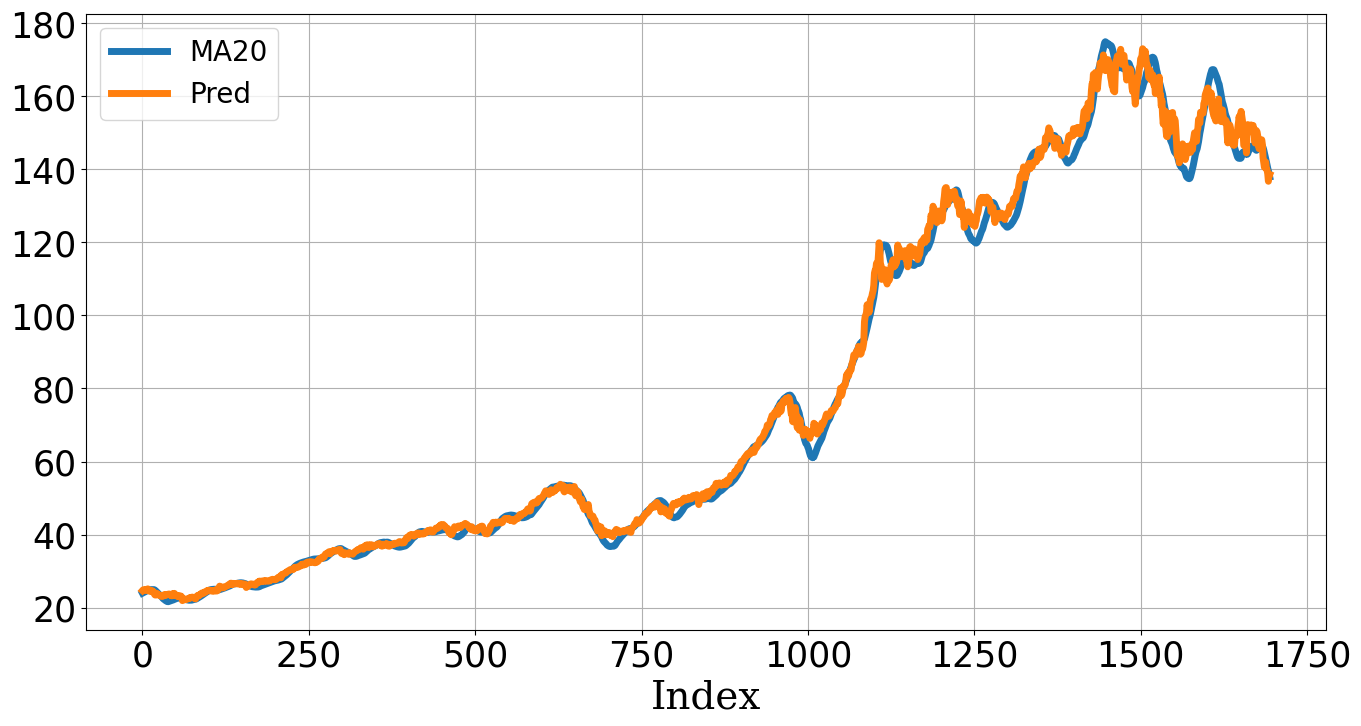

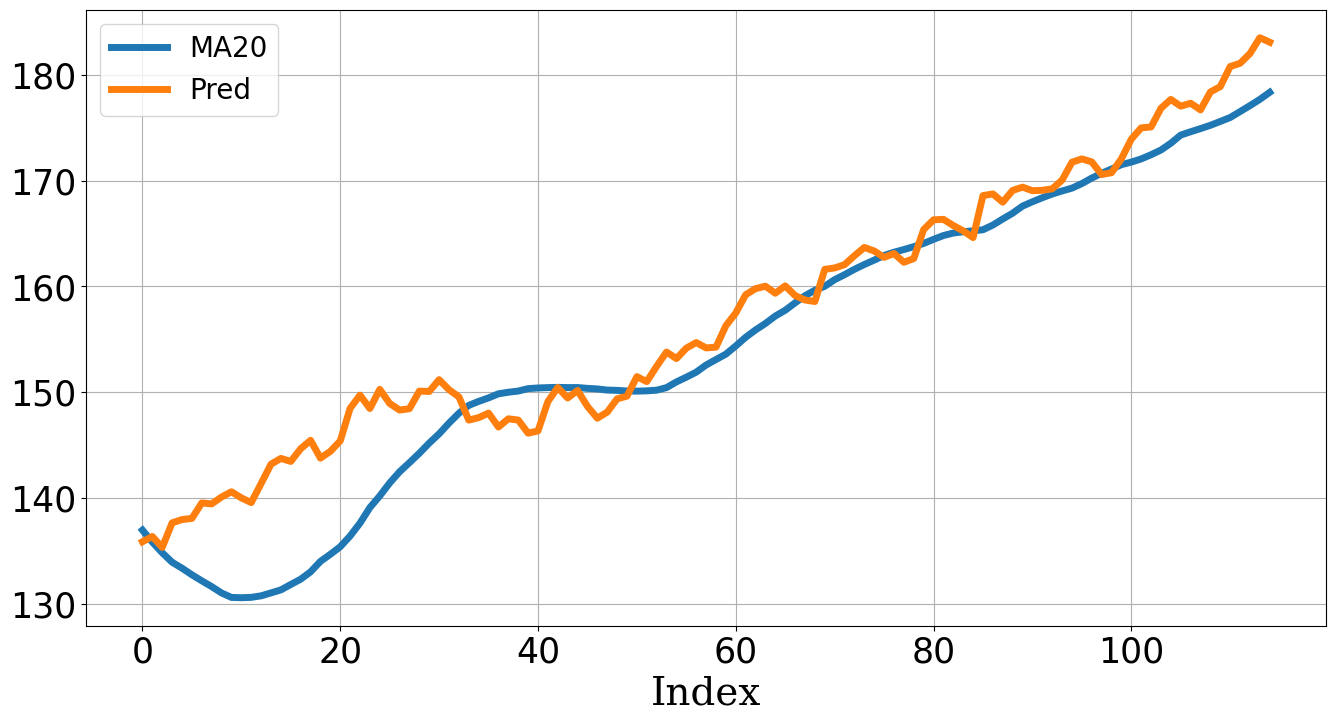

,MAE,MSE,MAPE
Train,2.13,9.75,0.03
Test,3.64,24.84,0.03


In [37]:
# load best model
model = load_model(FILENAME)

## 예측하기
Y_trpred = pd.DataFrame(model.predict(X_train), 
                        index=Y_train.index, columns=['Pred'])
Y_tepred = pd.DataFrame(model.predict(X_test), 
                        index=Y_test.index, columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score_nn_early = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_nn_early)

# CNN

In [38]:
# 하이퍼파라미터
tf.random.set_seed(1)
KERNEL_SIZE = 3
STRIDE = 1
POOL_SIZE = 2
POOL_STRIDE = 2
PADDING = 'same'
HIDDEN_ACTIVATION = 'relu'
OUTPUT_ACTIVATION = 'linear'
REGULARIZER = regularizers.l2(0.01)
DROPOUT_RATIO = 0.25
LOSS = 'mse'
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['mse']
BATCH_SIZE = 64
EPOCHS = 100
VERBOSE = 0
################
EARLYSTOP_PATIENT = 20
MONITOR = 'val_loss'
FILENAME = os.path.join(os.getcwd(),'Model','apple_CNN.h5')
CALLBACK = [callbacks.EarlyStopping(monitor=MONITOR, mode='min', 
                                    patience=EARLYSTOP_PATIENT, verbose=1),
            tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
            callbacks.ModelCheckpoint(monitor=MONITOR, mode='min', save_best_only=True, 
                                      filepath=FILENAME)]
################


In [39]:
# reshape
X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_test = X_test.reshape(-1, X_test.shape[1], 1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

X_train: (1695, 17, 1) Y_train: (1695, 1)
X_test: (115, 17, 1) Y_test: (115, 1)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 17, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 17, 128)           512       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8, 128)           0         
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 8, 128)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 64)             24640     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4, 64)            0         
 1D)                                                       

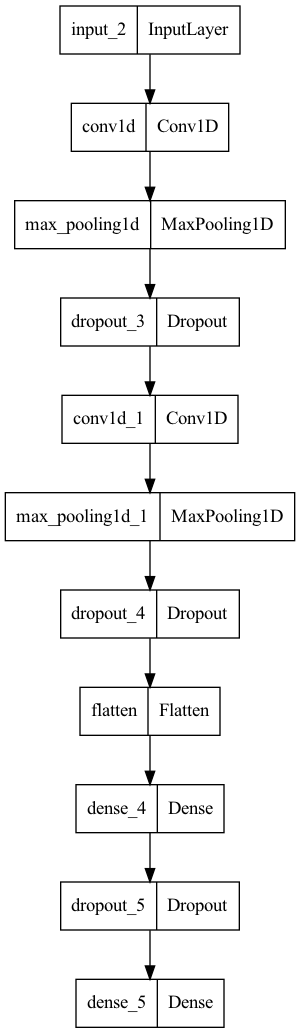

In [40]:
# build network
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))   
hiddens = Conv1D(128, kernel_size=KERNEL_SIZE, strides=STRIDE, padding=PADDING, 
                 activation=HIDDEN_ACTIVATION)(inputs)
hiddens = MaxPooling1D(pool_size=POOL_SIZE, strides=POOL_STRIDE)(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Conv1D(64, kernel_size=KERNEL_SIZE, strides=STRIDE, padding=PADDING, 
                 activation=HIDDEN_ACTIVATION)(hiddens)
hiddens = MaxPooling1D(pool_size=POOL_SIZE, strides=POOL_STRIDE)(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Flatten()(hiddens)
hiddens = Dense(32, activation=HIDDEN_ACTIVATION)(hiddens)  
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
output = Dense(1, activation=OUTPUT_ACTIVATION)(hiddens)  
model = Model(inputs, output)  
model.summary() 
plot_model(model) 

Training:   0%|           0/100 ETA: ?s,  ?epochs/s2023-06-24 09:32:55.407216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-24 09:32:59.490606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Training:  37%|███▋       37/100 ETA: 00:25s,   2.46epochs/s

Epoch 37: early stopping


Training:  37%|███▋       37/100 ETA: 00:32s,   1.96epochs/s


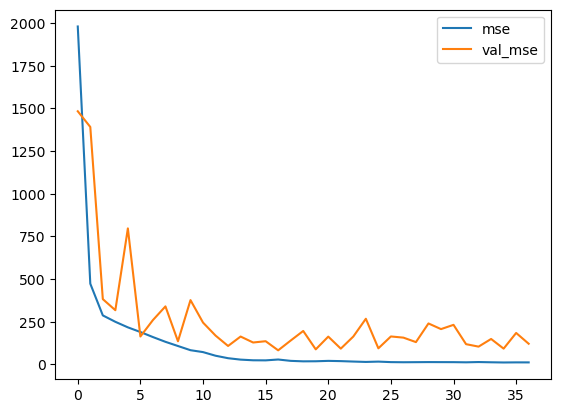

In [41]:
## 데이터 학습하기
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
model_fit = model.fit(X_train, Y_train, validation_split=0.2,
                      batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE,
                      callbacks=CALLBACK)
plt.plot(pd.DataFrame(model_fit.history[METRICS[0]]))
plt.plot(pd.DataFrame(model_fit.history['val_'+METRICS[0]]))
plt.legend([METRICS[0], 'val_'+METRICS[0]])
plt.show()

26/53 [=============>................] - ETA: 0s

2023-06-24 09:33:14.005285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 11ms/step


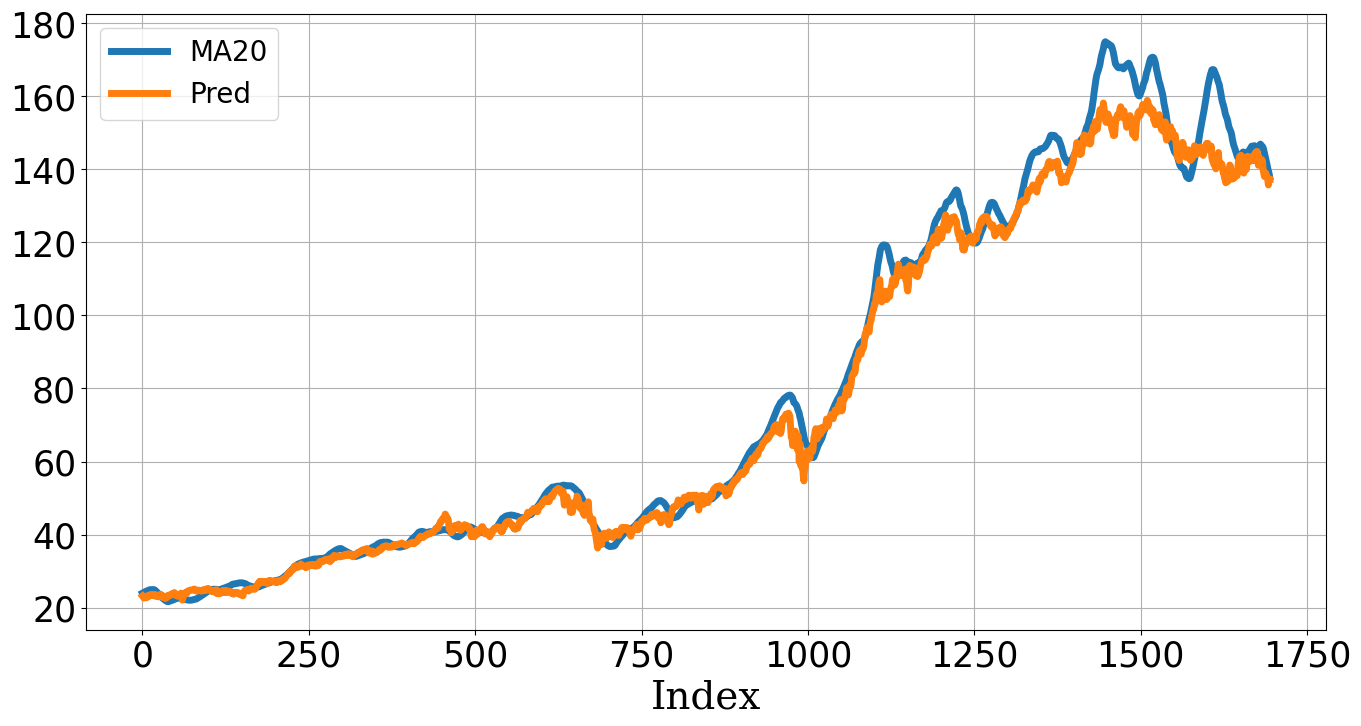

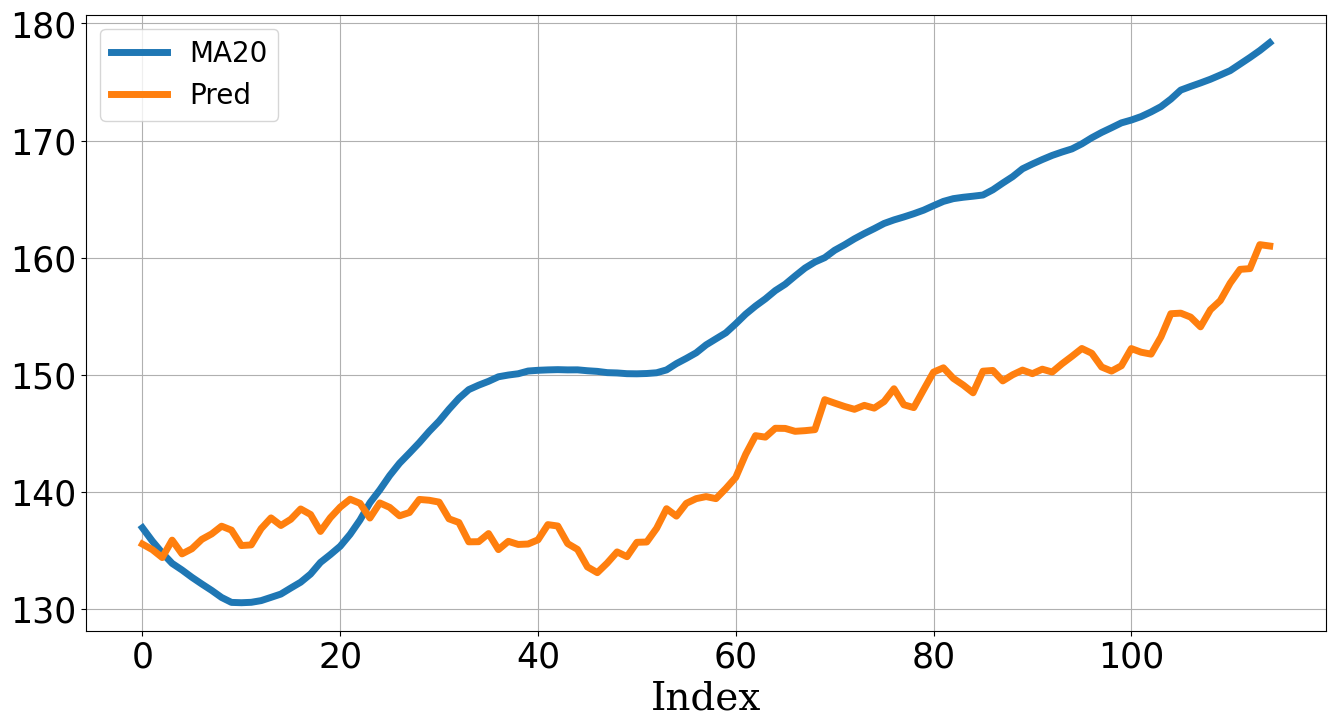

,MAE,MSE,MAPE
Train,3.70,33.94,0.04
Test,12.40,186.80,0.08


In [42]:
## 예측하기
Y_trpred = pd.DataFrame(model.predict(X_train), 
                        index=Y_train.index, columns=['Pred'])
Y_tepred = pd.DataFrame(model.predict(X_test), 
                        index=Y_test.index, columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score_nn_early = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_nn_early)

28/53 [==============>...............] - ETA: 0s

2023-06-24 09:33:15.366832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 19ms/step


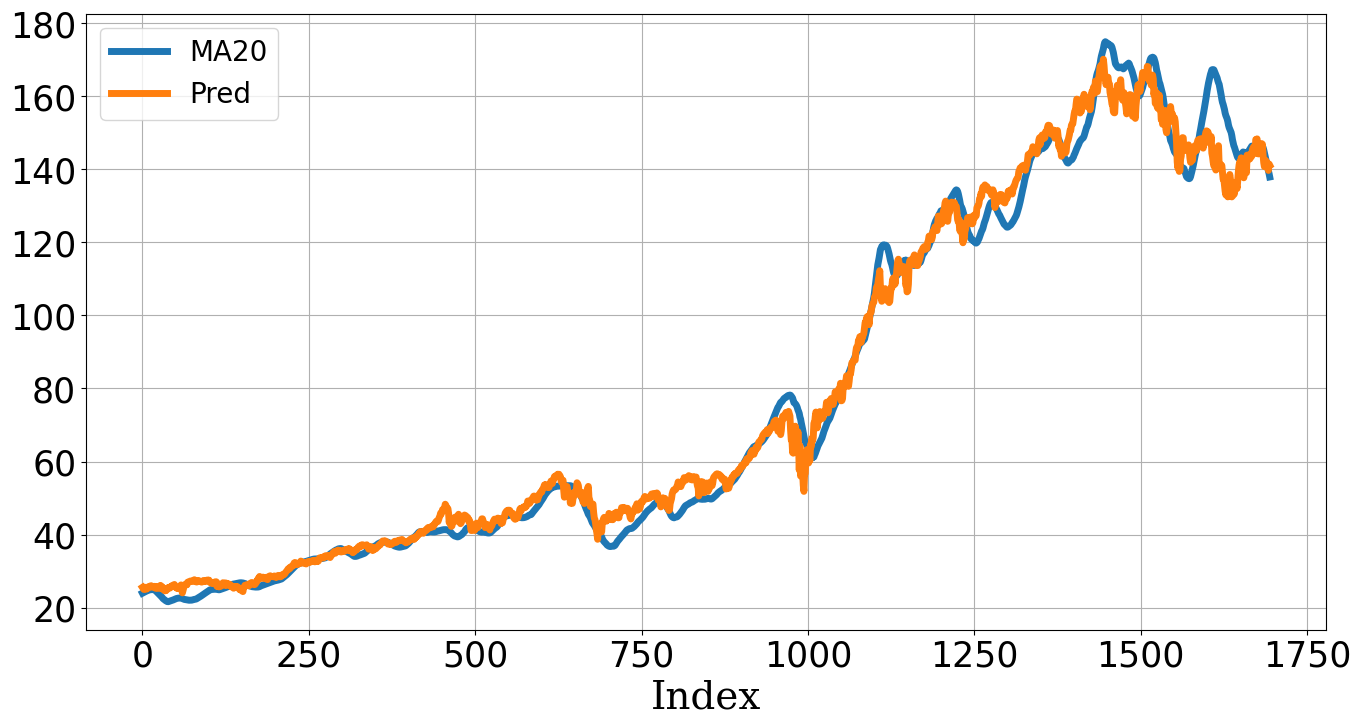

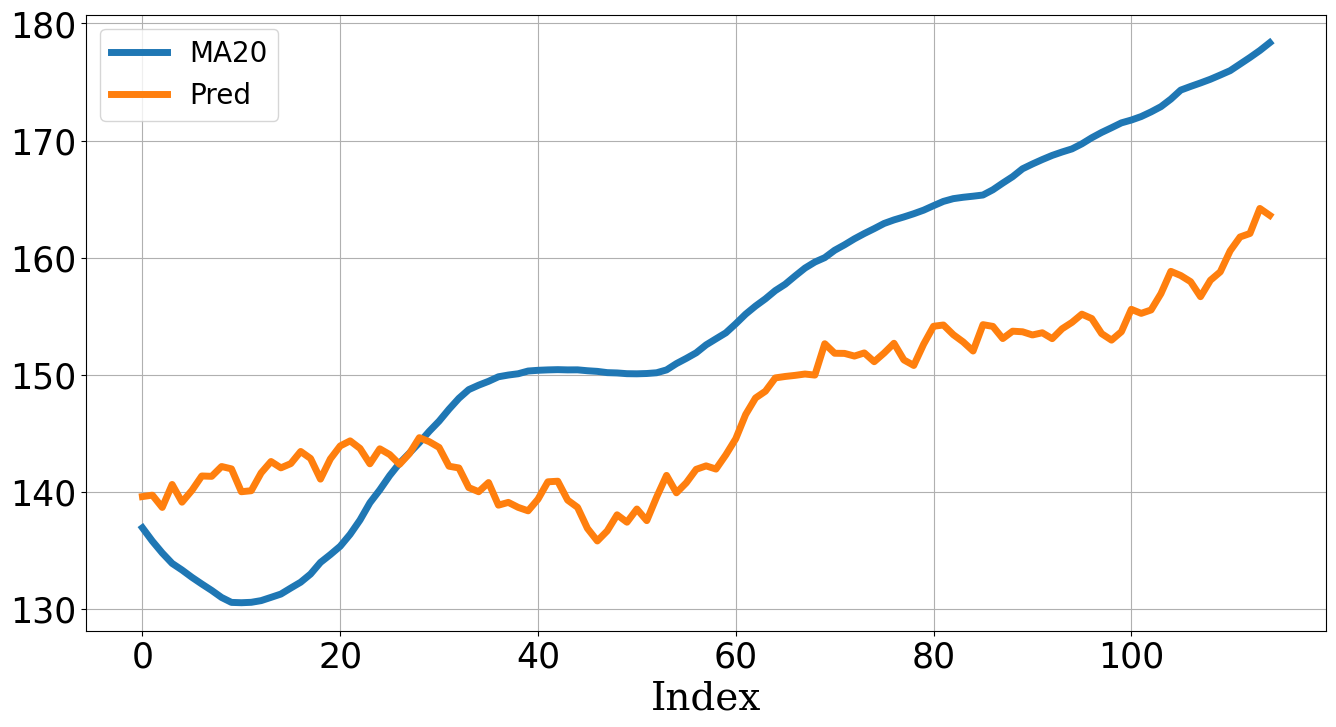

,MAE,MSE,MAPE
Train,3.77,30.25,0.05
Test,10.64,129.61,0.07


In [43]:
# 베스트 모델 로딩
model = load_model(FILENAME)

## 예측하기
Y_trpred = pd.DataFrame(model.predict(X_train), 
                        index=Y_train.index, columns=['Pred'])
Y_tepred = pd.DataFrame(model.predict(X_test), 
                        index=Y_test.index, columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score_nn_early = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_nn_early)

# RNN

In [44]:
# Hyperparameters
SEQUENCE = 12
tf.random.set_seed(1)
KERNEL_SIZE = 3
STRIDE = 1
POOL_SIZE = 2
POOL_STRIDE = 2
PADDING = 'same'
HIDDEN_ACTIVATION = 'relu'
OUTPUT_ACTIVATION = 'linear'
REGULARIZER = regularizers.l2(0.01)
DROPOUT_RATIO = 0.25
LOSS = 'mse'
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['mse']
BATCH_SIZE = 64
EPOCHS = 100
VERBOSE = 0
##########
EARLYSTOP_PATIENT = 10
MONITOR = 'val_loss'
FILENAME = os.path.join(os.getcwd(), 'Model', 'apple_RNN.h5')
CALLBACK = [callbacks.EarlyStopping(monitor=MONITOR, mode='min',
                                    patience=EARLYSTOP_PATIENT, verbose=1),
            tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
            callbacks.ModelCheckpoint(filepath=FILENAME, monitor=MONITOR, mode='min', save_best_only=True)]
##########

In [45]:
# # sequence 데이터 추출 및 변환
# seq_length = 12
# X_reshape, Y_resahpe = [], []
# for index in range(len(X_train) - seq_length + 1):
#     X_reshape.append(np.array(X_train[index: index + seq_length]))      # sequence 길이의 row 선택 후 붙이기
#     Y_resahpe.append(np.ravel(Y_train[index + seq_length - 1: index + seq_length]))  # sequence 길이를 제외하고 1개씩 붙이기

# # arrange
# X_reshape, Y_resahpe = np.array(X_reshape), np.array(Y_resahpe)
# Y_resahpe = pd.DataFrame(Y_resahpe, index=Y_train.index[seq_length-1:], columns=Y_train.columns)
# print('origin X: ', X_train.shape, '-> reshape X: ', X_reshape.shape)
# print('origin Y: ', Y_train.shape, '-> reshape Y: ', Y_resahpe.shape)

In [46]:
# reshape 함수화
def reshape_2Dto3Dseq(df_X, df_Y, seq_length):
    # generate sequence
    X_reshape, Y_resahpe = [], []
    for index in range(len(df_X) - seq_length + 1):
        X_reshape.append(np.array(df_X[index: index + seq_length]))      # sequence 길이의 row 선택 후 붙이기
        Y_resahpe.append(np.ravel(df_Y[index + seq_length - 1: index + seq_length]))    # sequence 길이를 제외하고 1개씩 붙이기
    
    # arrange
    X_reshape, Y_resahpe = np.array(X_reshape), np.array(Y_resahpe)
    Y_resahpe = pd.DataFrame(Y_resahpe, index=df_Y.index[seq_length-1:], columns=df_Y.columns)

    print('origin X: ', df_X.shape, '-> reshape X: ', X_reshape.shape)
    print('origin Y: ', df_Y.shape, '-> reshape Y: ', Y_resahpe.shape)

    return X_reshape, Y_resahpe

SEQUENCE = 12
X, Y = reshape_2Dto3Dseq(X_train, Y_train, SEQUENCE)

origin X:  (1695, 17, 1) -> reshape X:  (1684, 12, 17, 1)
origin Y:  (1695, 1) -> reshape Y:  (1684, 1)


In [47]:
# train & test 형태 변경
X, Y = reshape_2Dto3Dseq(np.concatenate((X_train, X_test), axis=0),     # numpy series 합치기 -> np.concatenate
                         pd.concat([Y_train, Y_test], axis=0), SEQUENCE) # pandas series 합치기 -> pd.concat
test_length = Y_test.shape[0]
X_train, Y_train = X[:-test_length], Y.iloc[:-test_length]
X_test, Y_test = X[-test_length:], Y.iloc[-test_length:]
print('X_train: ', X_train.shape, 'Y_train: ', Y_train.shape)
print('X_test: ', X_test.shape, 'Y_test: ', Y_test.shape)

origin X:  (1810, 17, 1) -> reshape X:  (1799, 12, 17, 1)
origin Y:  (1810, 1) -> reshape Y:  (1799, 1)
X_train:  (1684, 12, 17, 1) Y_train:  (1684, 1)
X_test:  (115, 12, 17, 1) Y_test:  (115, 1)


In [48]:
# 데이터 백업
X_trprep3D, X_teprep3D = X_train.copy(), X_test.copy()
Y_trprep3D, Y_teprep3D = Y_train.copy(), Y_test.copy()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 12, 17)]          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 12, 128)           18688     
                                                                 
 dropout_6 (Dropout)         (None, 12, 128)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 12, 64)            12352     
                                                                 
 dropout_7 (Dropout)         (None, 12, 64)            0         
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 769 

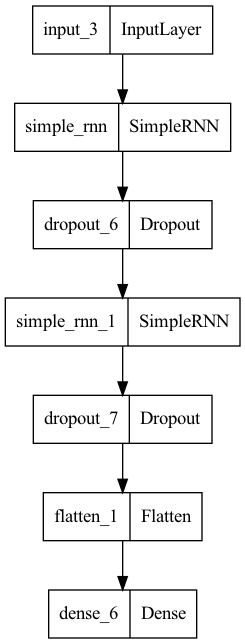

In [49]:
# model
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
hiddens = SimpleRNN(128, return_sequences=True,         # return_sequences=True -> 매 시점 Y값 출력 (many to many) / False -> 맨 마지막 Y값 출력 (many to one)
                    activation=HIDDEN_ACTIVATION)(inputs)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = SimpleRNN(64, return_sequences=True,
                    activation=HIDDEN_ACTIVATION)(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Flatten()(hiddens)
output = Dense(1, activation=OUTPUT_ACTIVATION)(hiddens)
model = Model(inputs, output)
model.summary()
plot_model(model)

Training:   0%|           0/100 ETA: ?s,  ?epochs/s2023-06-24 09:33:18.046153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-24 09:33:26.496954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Training:  12%|█▏         12/100 ETA: 09:23s,   6.41s/epochs

Epoch 12: early stopping


Training:  12%|█▏         12/100 ETA: 09:44s,   6.64s/epochs


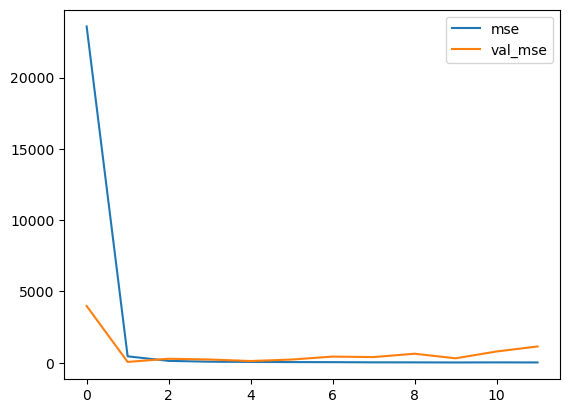

In [50]:
# fit datasets
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
model_fit = model.fit(X_train, Y_train, validation_split=0.2,
                      batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE,
                      callbacks=CALLBACK)
plt.plot(pd.DataFrame(model_fit.history[METRICS[0]]))
plt.plot(pd.DataFrame(model_fit.history['val_'+METRICS[0]]))
plt.legend([METRICS[0], 'val_'+METRICS[0]])
plt.show()

 1/53 [..............................] - ETA: 20s

2023-06-24 09:34:37.553797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 55ms/step


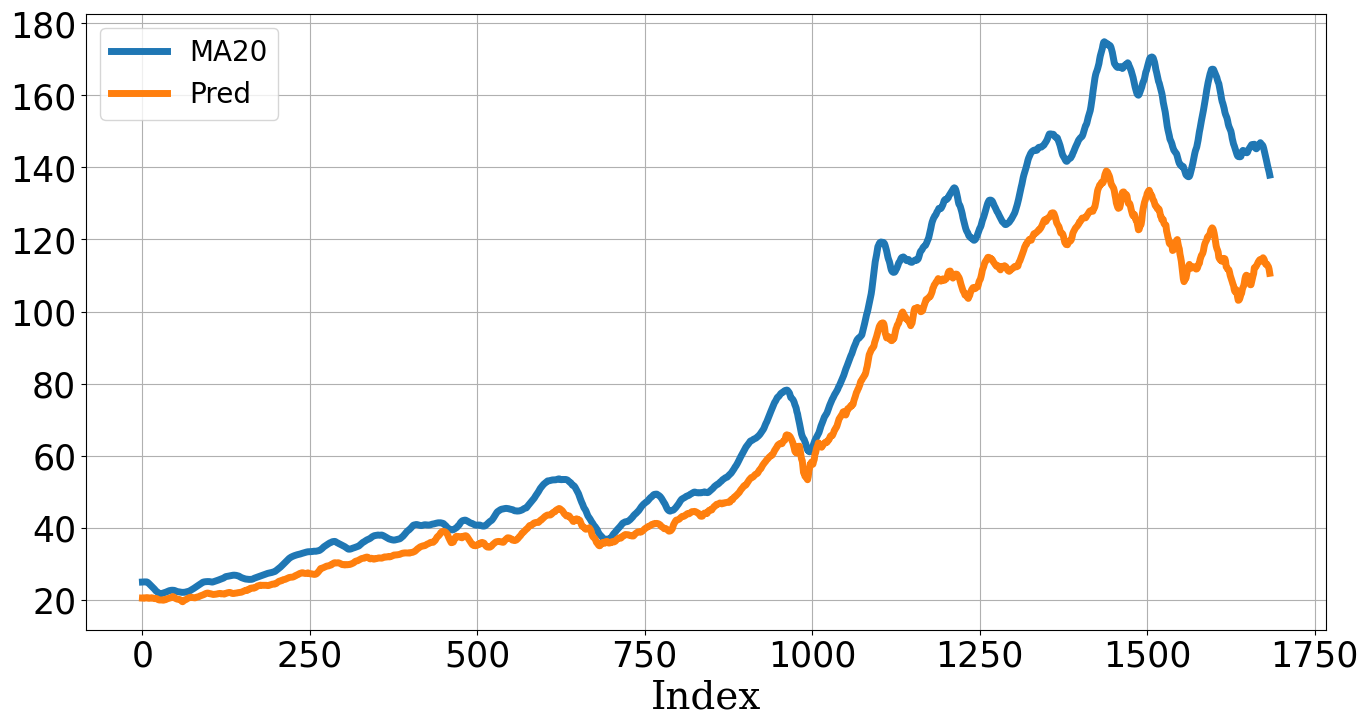

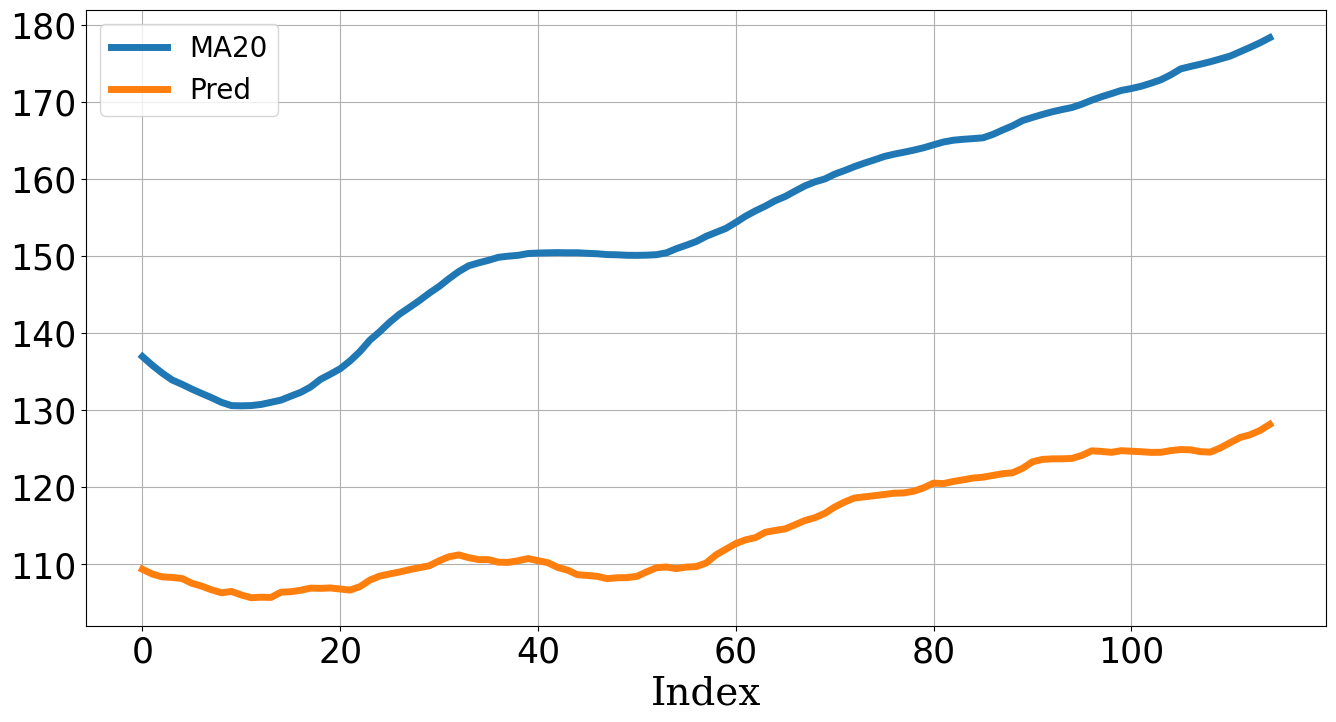

In [51]:
## 예측하기
Y_trpred = pd.DataFrame(model.predict(X_train), 
                        index=Y_train.index, columns=['Pred'])
Y_tepred = pd.DataFrame(model.predict(X_test), 
                        index=Y_test.index, columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

In [52]:
# 분석 검증
Score_nn_early = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_nn_early)

,MAE,MSE,MAPE
Train,13.35,310.70,0.15
Test,39.59,"1,627.94",0.25


 1/53 [..............................] - ETA: 11s

2023-06-24 09:34:40.986514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 54ms/step


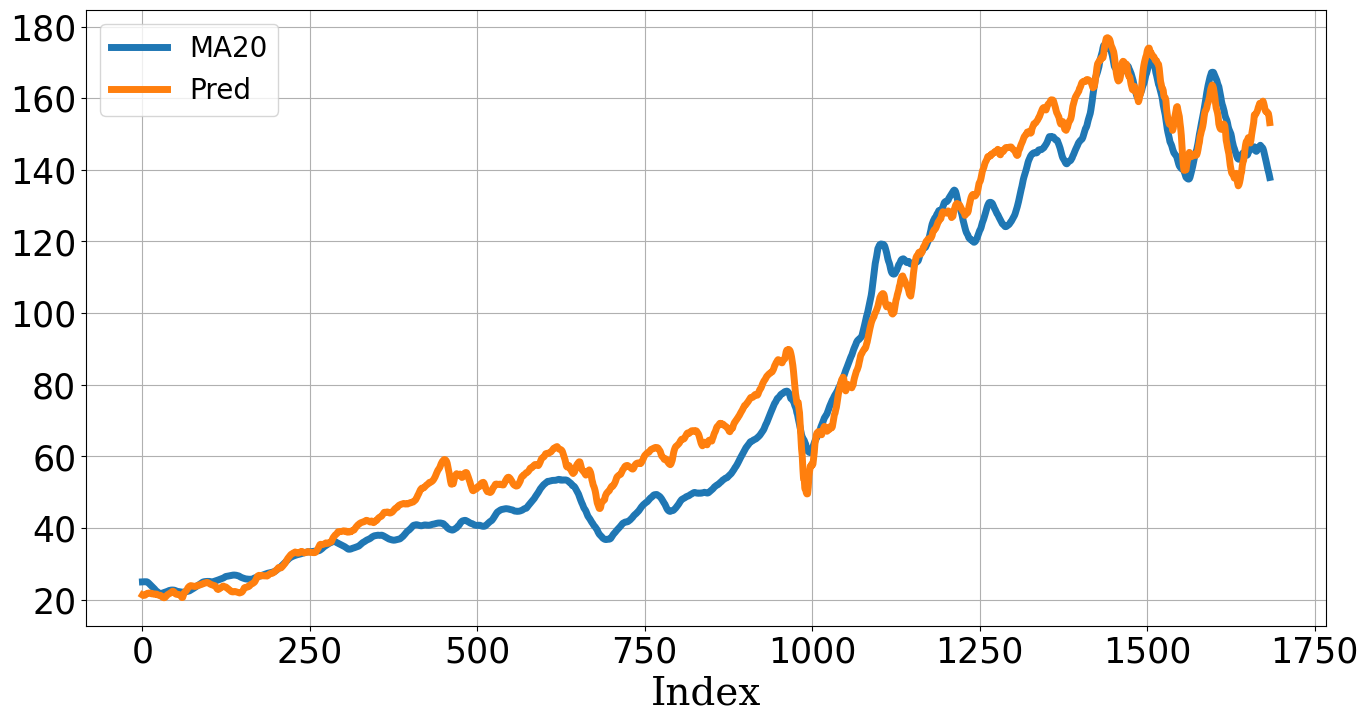

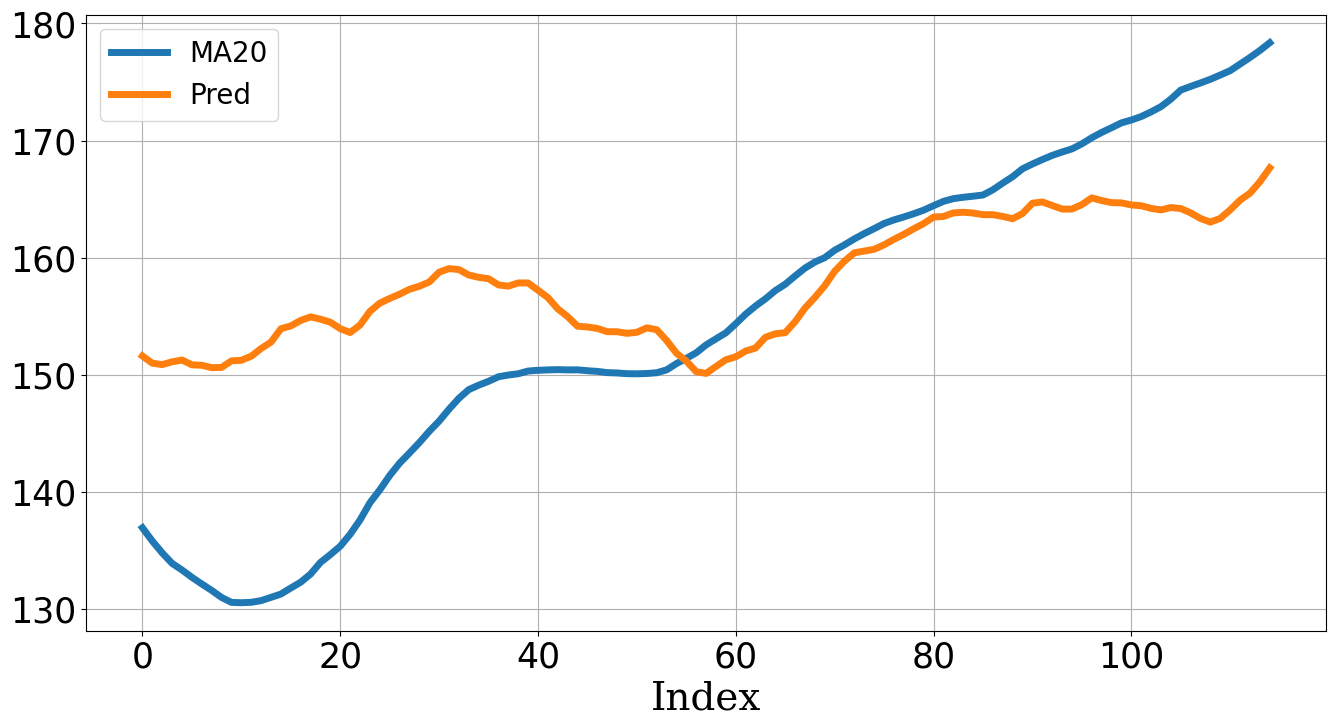

,MAE,MSE,MAPE
Train,7.60,86.06,0.13
Test,8.54,117.36,0.06


In [53]:
# 베스트 모델 로딩
model = load_model(FILENAME)

## 예측하기
Y_trpred = pd.DataFrame(model.predict(X_train), 
                        index=Y_train.index, columns=['Pred'])
Y_tepred = pd.DataFrame(model.predict(X_test), 
                        index=Y_test.index, columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score_nn_early = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_nn_early)


# LSTM

In [54]:
# Hyperparameters
SEQUENCE = 12
tf.random.set_seed(1)
KERNEL_SIZE = 3
STRIDE = 1
POOL_SIZE = 2
POOL_STRIDE = 2
PADDING = 'same'
HIDDEN_ACTIVATION = 'relu'
OUTPUT_ACTIVATION = 'linear'
REGULARIZER = regularizers.l2(0.01)
DROPOUT_RATIO = 0.25
LOSS = 'mse'
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['mse']
BATCH_SIZE = 64
EPOCHS = 100
VERBOSE = 0
##########
EARLYSTOP_PATIENT = 10
MONITOR = 'val_loss'
FILENAME = os.path.join(os.getcwd(), 'Model', 'apple_LSTM.h5')
CALLBACK = [callbacks.EarlyStopping(monitor=MONITOR, mode='min',
                                    patience=EARLYSTOP_PATIENT, verbose=1),
            tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
            callbacks.ModelCheckpoint(filepath=FILENAME, monitor=MONITOR, mode='min', save_best_only=True)]
##########

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 12, 17)]          0         
                                                                 
 lstm (LSTM)                 (None, 12, 128)           74752     
                                                                 
 dropout_8 (Dropout)         (None, 12, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 12, 64)            49408     
                                                                 
 dropout_9 (Dropout)         (None, 12, 64)            0         
                                                                 
 flatten_2 (Flatten)         (None, 768)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 769 

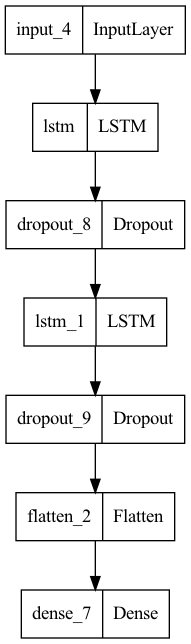

In [55]:
# model
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
hiddens = LSTM(128, return_sequences=True,         # return_sequences=True -> 매 시점 Y값 출력 (many to many) / False -> 맨 마지막 Y값 출력 (many to one)
               activation=HIDDEN_ACTIVATION)(inputs)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = LSTM(64, return_sequences=True,
               activation=HIDDEN_ACTIVATION)(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Flatten()(hiddens)
output = Dense(1, activation=OUTPUT_ACTIVATION)(hiddens)
model = Model(inputs, output)
model.summary()
plot_model(model)

Training:   0%|           0/100 ETA: ?s,  ?epochs/s2023-06-24 09:34:46.167275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-24 09:35:01.222816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Training:  15%|█▌         15/100 ETA: 18:05s,  12.77s/epochs

Epoch 15: early stopping


Training:  15%|█▌         15/100 ETA: 18:52s,  13.32s/epochs


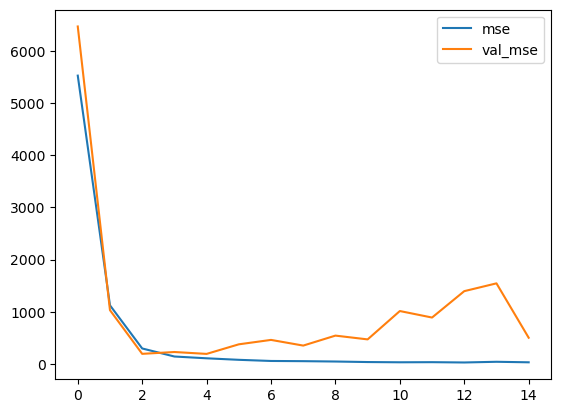

In [56]:
# fit datasets
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
model_fit = model.fit(X_train, Y_train, validation_split=0.2,
                      batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE,
                      callbacks=CALLBACK)
plt.plot(pd.DataFrame(model_fit.history[METRICS[0]]))
plt.plot(pd.DataFrame(model_fit.history['val_'+METRICS[0]]))
plt.legend([METRICS[0], 'val_'+METRICS[0]])
plt.show()

2023-06-24 09:38:05.343075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 120ms/step


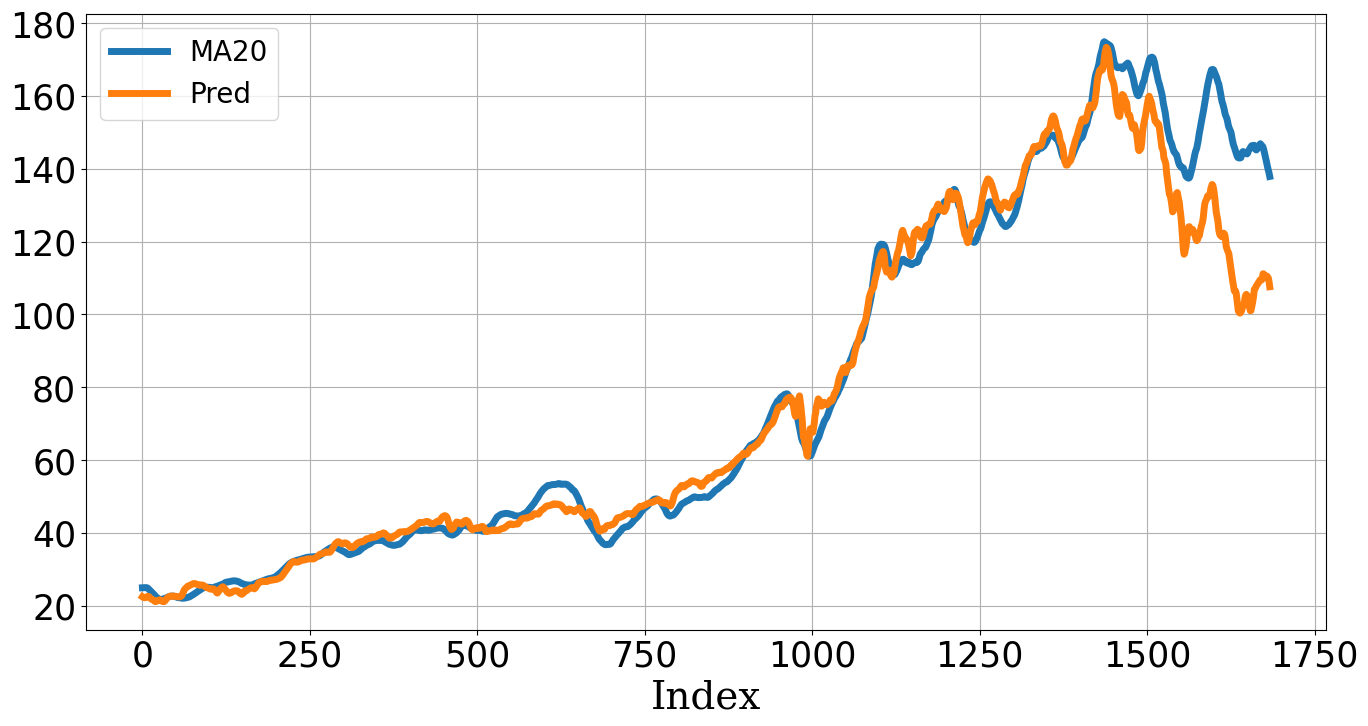

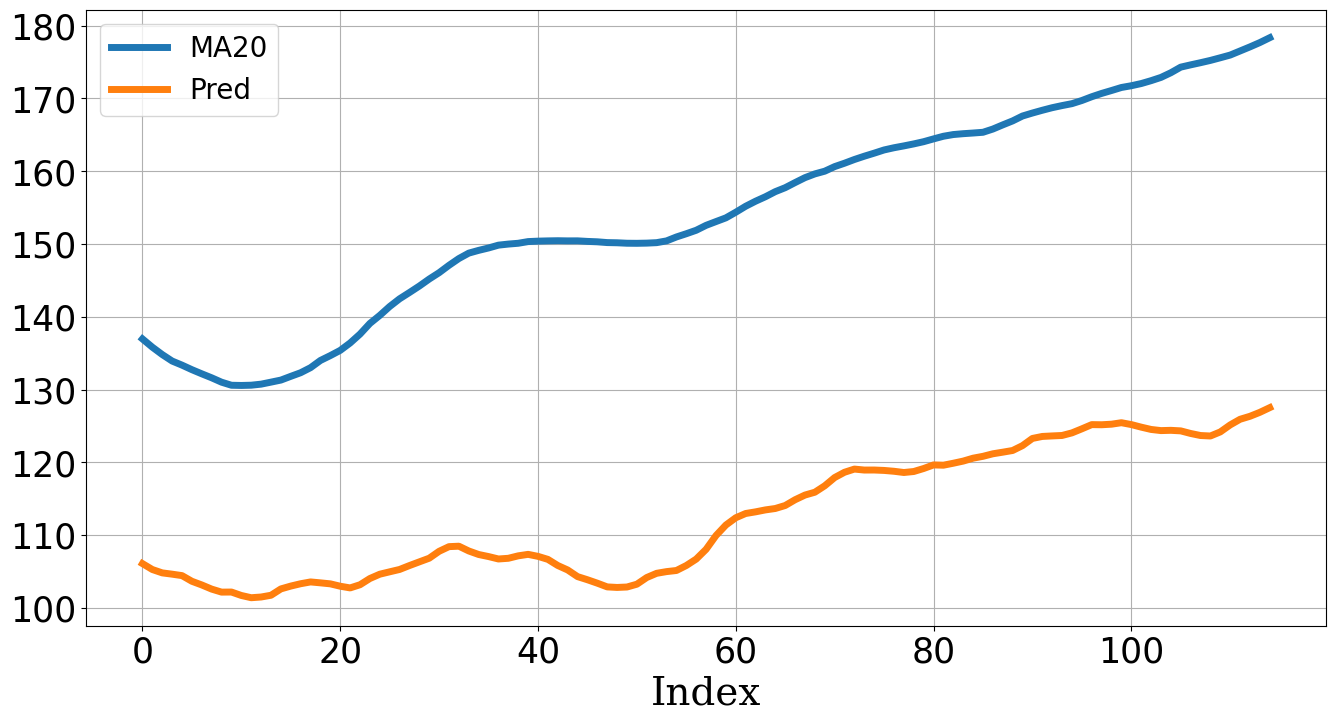

In [57]:
## 예측하기
Y_trpred = pd.DataFrame(model.predict(X_train), 
                        index=Y_train.index, columns=['Pred'])
Y_tepred = pd.DataFrame(model.predict(X_test), 
                        index=Y_test.index, columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

In [58]:
# 분석 검증
Score_nn_early = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_nn_early)

,MAE,MSE,MAPE
Train,5.53,108.87,0.06
Test,41.65,"1,778.81",0.27


2023-06-24 09:38:10.379012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 85ms/step


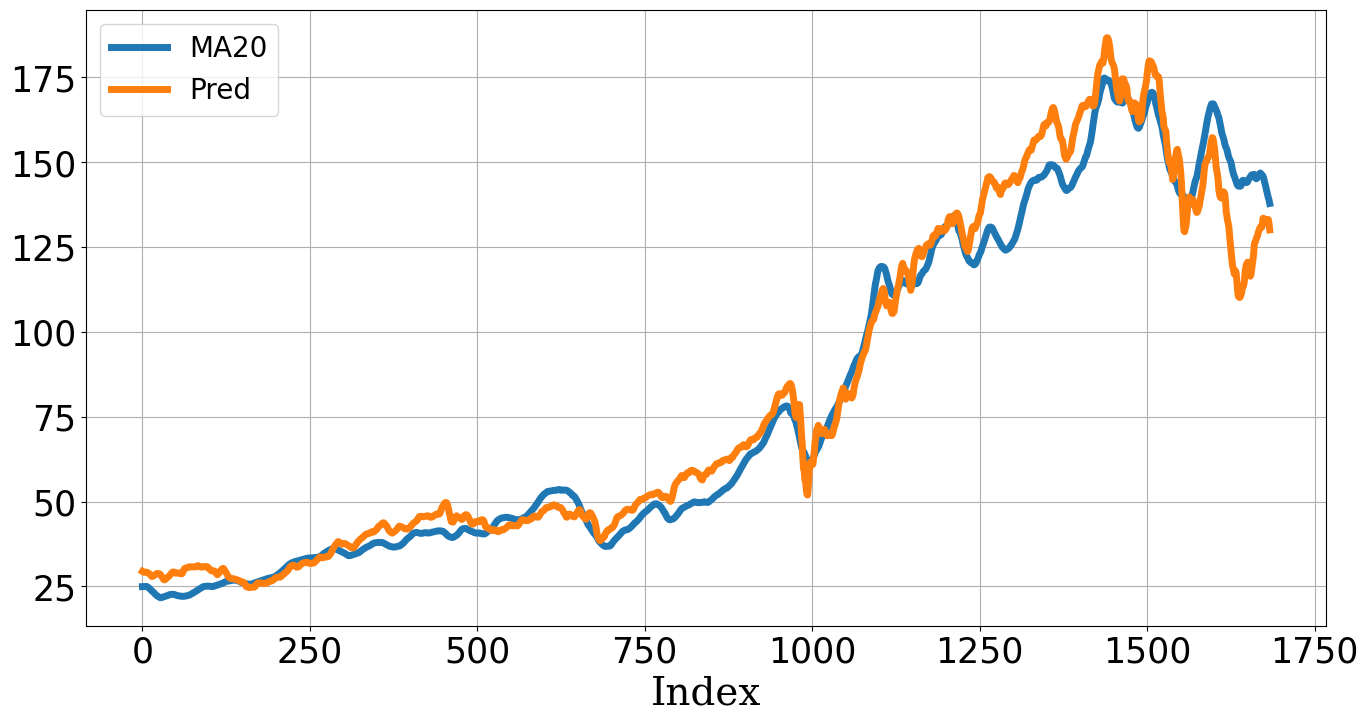

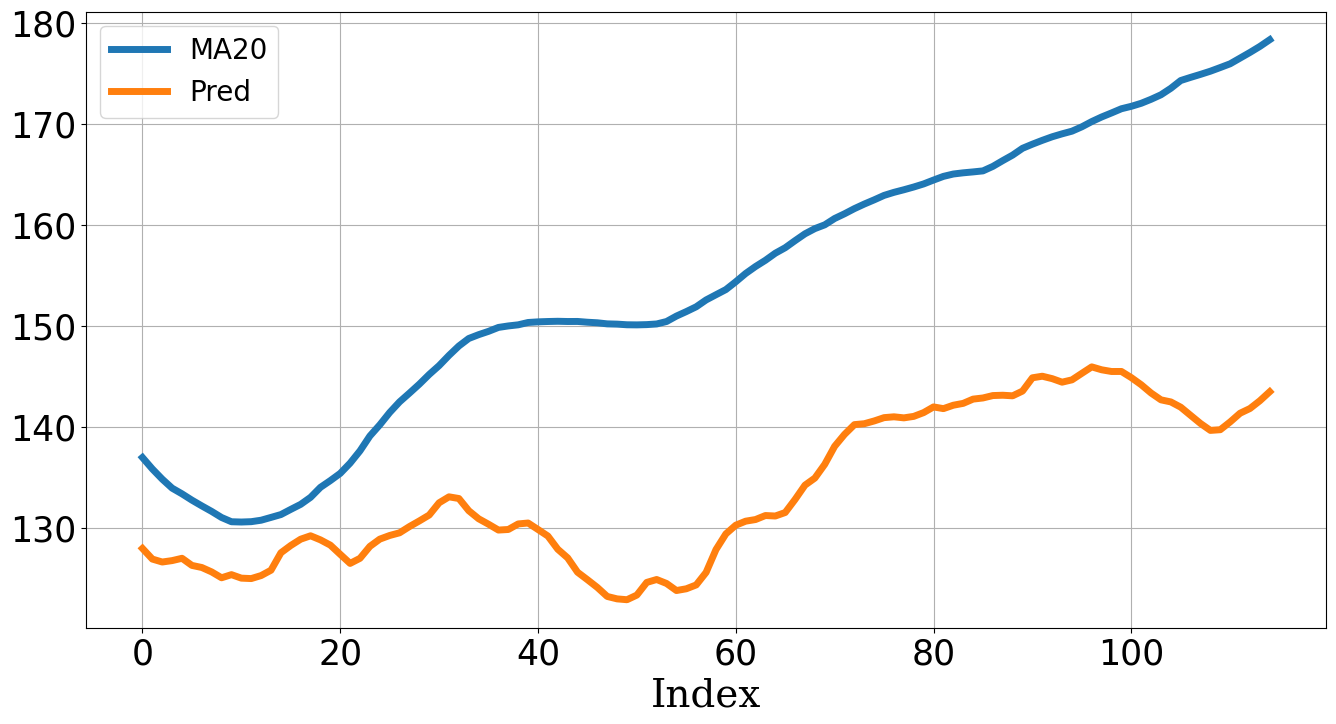

,MAE,MSE,MAPE
Train,6.26,69.20,0.09
Test,20.52,497.04,0.13


In [59]:
# 베스트 모델 로딩
model = load_model(FILENAME)

## 예측하기
Y_trpred = pd.DataFrame(model.predict(X_train), 
                        index=Y_train.index, columns=['Pred'])
Y_tepred = pd.DataFrame(model.predict(X_test), 
                        index=Y_test.index, columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score_nn_early = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_nn_early)

# GRU

In [60]:
# Hyperparameters
SEQUENCE = 12
tf.random.set_seed(1)
KERNEL_SIZE = 3
STRIDE = 1
POOL_SIZE = 2
POOL_STRIDE = 2
PADDING = 'same'
HIDDEN_ACTIVATION = 'relu'
OUTPUT_ACTIVATION = 'linear'
REGULARIZER = regularizers.l2(0.01)
DROPOUT_RATIO = 0.25
LOSS = 'mse'
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['mse']
BARCH_SIZE = 64
EPOCHS = 100
VERBOSE = 0
##########
EARLYSTOP_PATIENT = 10
MONITOR = 'val_loss'
FILENAME = os.path.join(os.getcwd(), 'Model', 'apple_GRU.h5')
CALLBACK = [callbacks.EarlyStopping(monitor=MONITOR, mode='min',
                                    patience=EARLYSTOP_PATIENT, verbose=1),
            tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
            callbacks.ModelCheckpoint(filepath=FILENAME, monitor=MONITOR, mode='min', save_best_only=True)]
##########

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 12, 17)]          0         
                                                                 
 gru (GRU)                   (None, 12, 128)           56448     
                                                                 
 dropout_10 (Dropout)        (None, 12, 128)           0         
                                                                 
 gru_1 (GRU)                 (None, 12, 64)            37248     
                                                                 
 dropout_11 (Dropout)        (None, 12, 64)            0         
                                                                 
 flatten_3 (Flatten)         (None, 768)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 769 

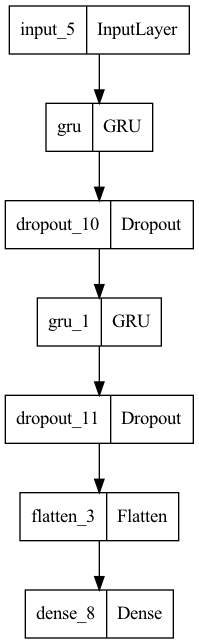

In [61]:
# model
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
hiddens = GRU(128, return_sequences=True,         # return_sequences=True -> 매 시점 Y값 출력 (many to many) / False -> 맨 마지막 Y값 출력 (many to one)
               activation=HIDDEN_ACTIVATION)(inputs)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = GRU(64, return_sequences=True,
               activation=HIDDEN_ACTIVATION)(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Flatten()(hiddens)
output = Dense(1, activation=OUTPUT_ACTIVATION)(hiddens)
model = Model(inputs, output)
model.summary()
plot_model(model)

Training:   0%|           0/100 ETA: ?s,  ?epochs/s2023-06-24 09:38:17.325691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-24 09:38:33.537461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Training:  13%|█▎         13/100 ETA: 21:49s,  15.05s/epochs

Epoch 13: early stopping


Training:  13%|█▎         13/100 ETA: 22:12s,  15.32s/epochs


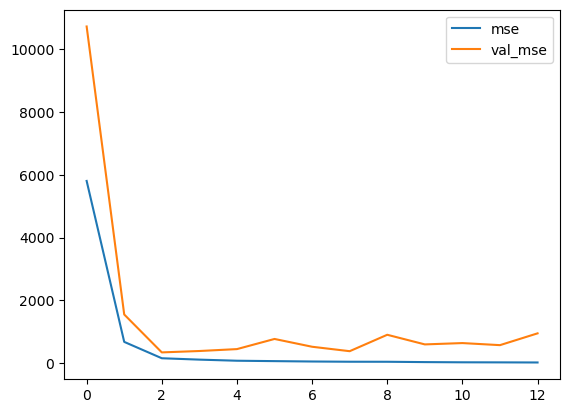

In [62]:
# fit datasets
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
model_fit = model.fit(X_train, Y_train, validation_split=0.2,
                      batch_size=BARCH_SIZE, epochs=EPOCHS, verbose=VERBOSE,
                      callbacks=CALLBACK)
plt.plot(pd.DataFrame(model_fit.history[METRICS[0]]))
plt.plot(pd.DataFrame(model_fit.history['val_'+METRICS[0]]))
plt.legend([METRICS[0], 'val_'+METRICS[0]])
plt.show()

2023-06-24 09:41:35.429174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 131ms/step


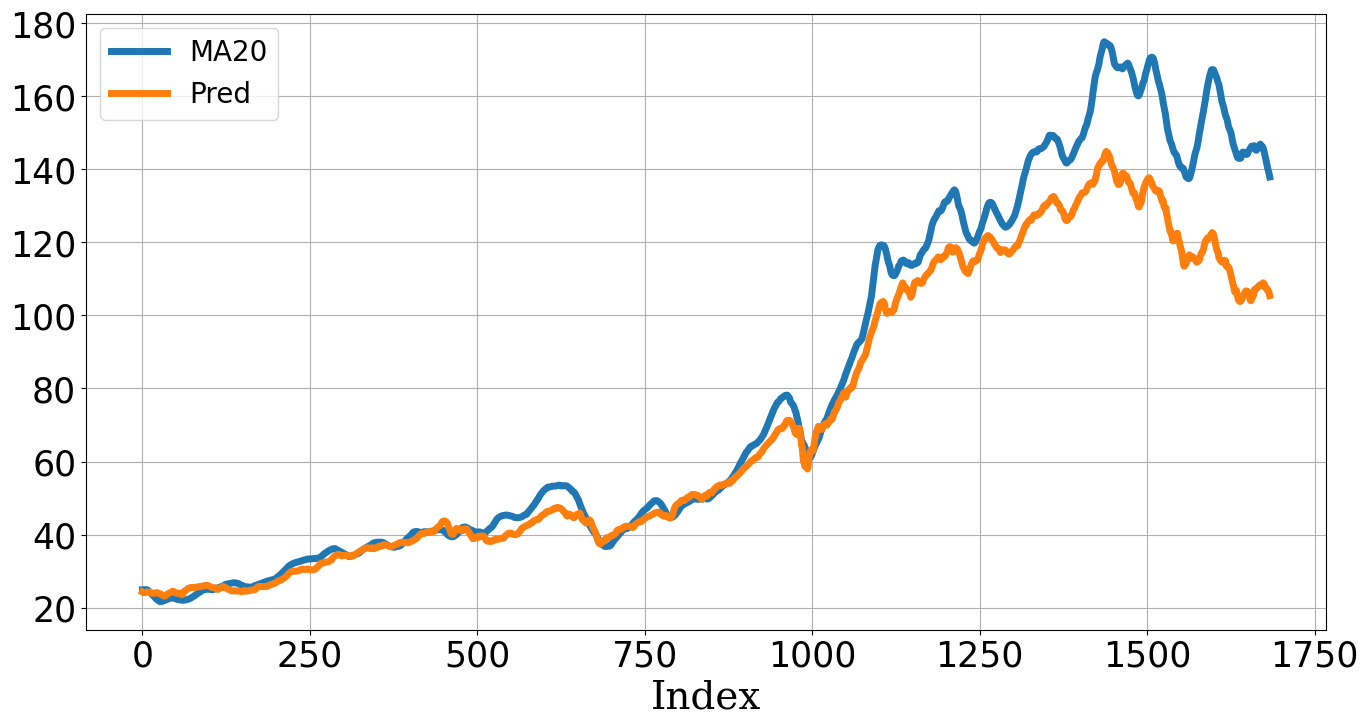

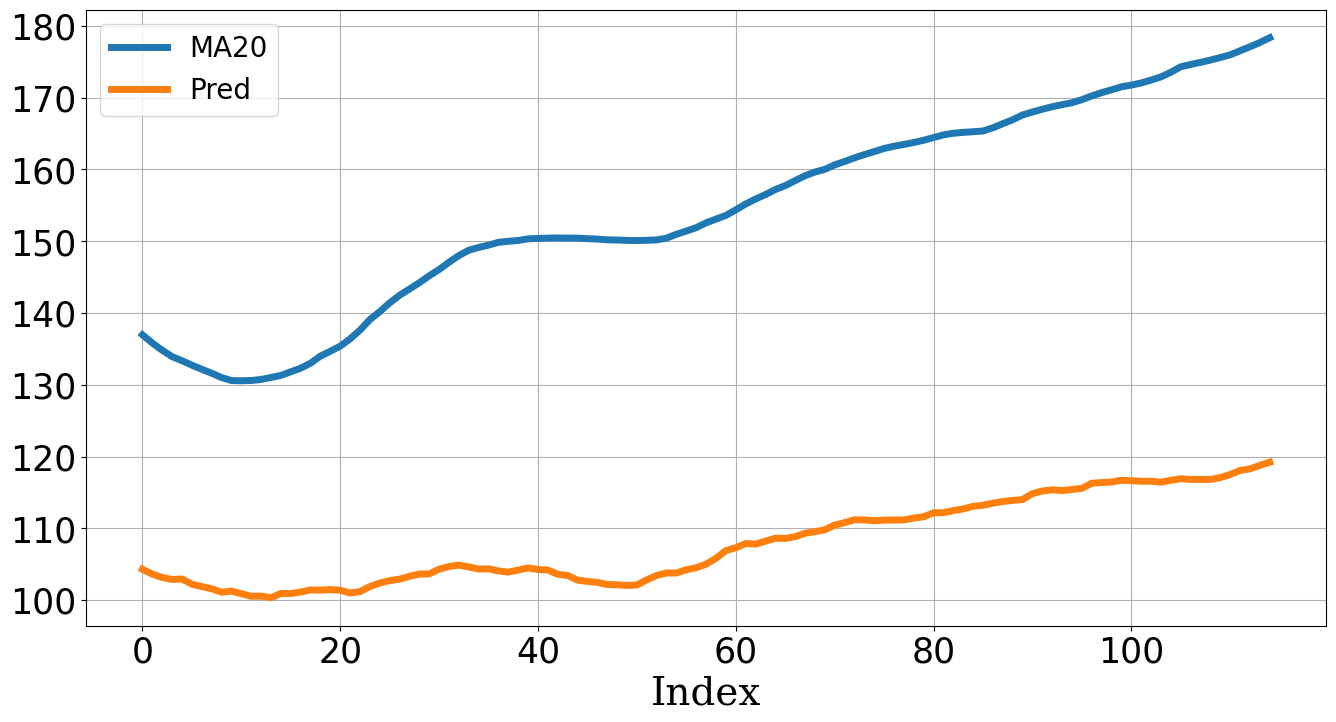

In [63]:
## 예측하기
Y_trpred = pd.DataFrame(model.predict(X_train), 
                        index=Y_train.index, columns=['Pred'])
Y_tepred = pd.DataFrame(model.predict(X_test), 
                        index=Y_test.index, columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

In [64]:
# 분석 검증
Score_nn_early = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_nn_early)

,MAE,MSE,MAPE
Train,9.17,217.85,0.09
Test,46.27,"2,217.60",0.30


2023-06-24 09:41:41.013785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 118ms/step


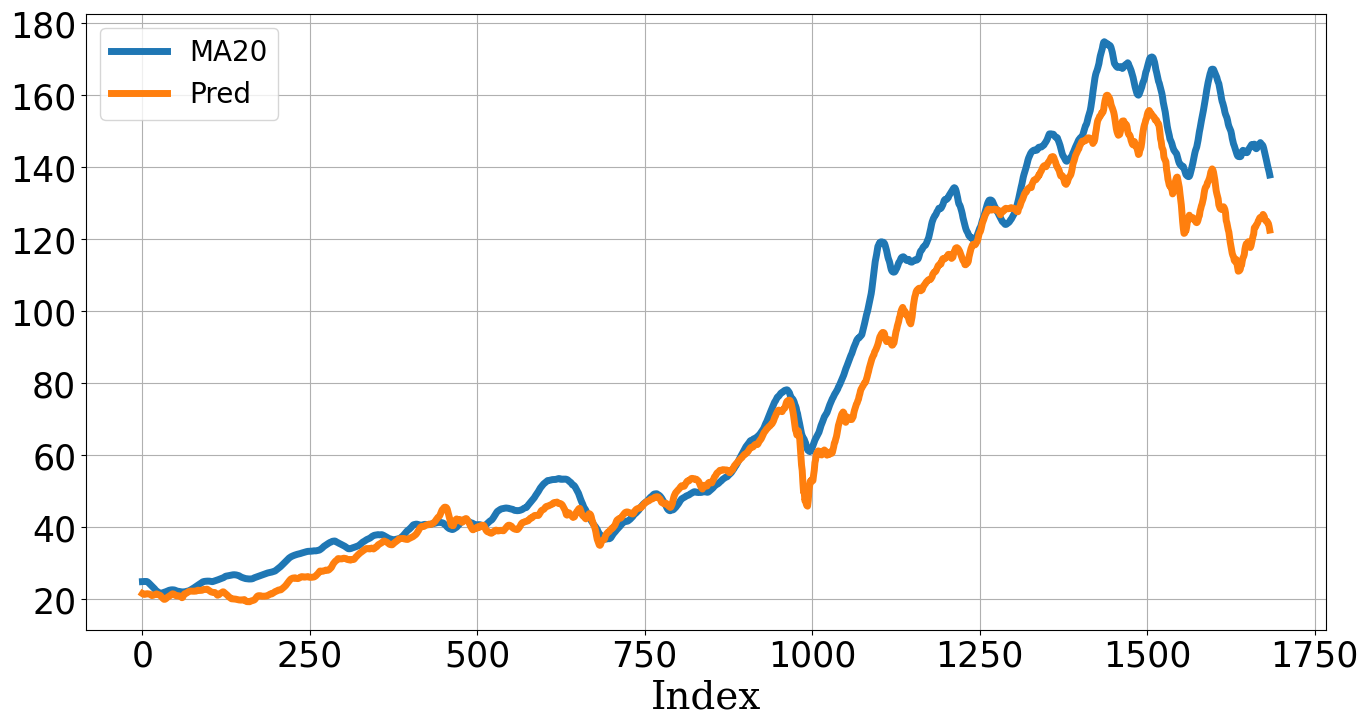

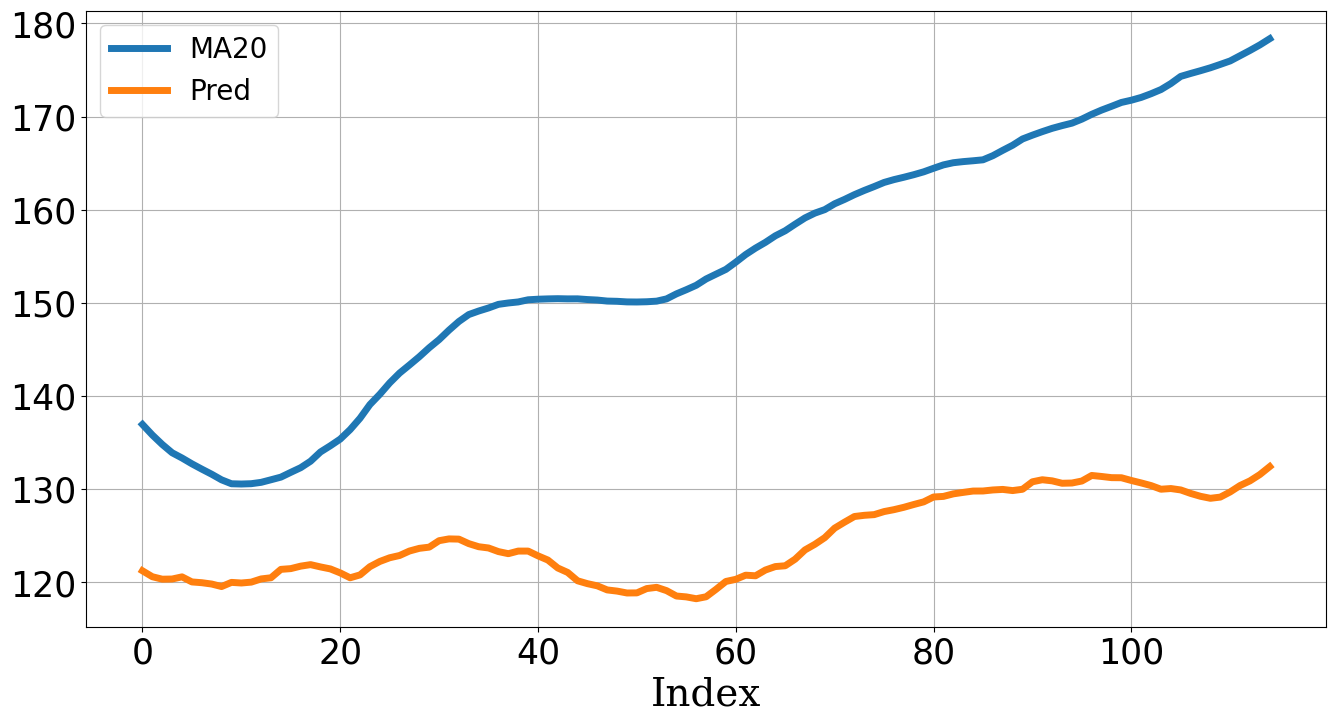

,MAE,MSE,MAPE
Train,7.72,116.54,0.10
Test,29.69,996.62,0.19


In [65]:
# 베스트 모델 로딩
model = load_model(FILENAME)

## 예측하기
Y_trpred = pd.DataFrame(model.predict(X_train), 
                        index=Y_train.index, columns=['Pred'])
Y_tepred = pd.DataFrame(model.predict(X_test), 
                        index=Y_test.index, columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score_nn_early = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_nn_early)

# Result Summary

MLP
4/4 [==============================] - 0s 22ms/step


2023-06-24 09:41:46.879655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


CNN
4/4 [==============================] - ETA: 0s

2023-06-24 09:41:47.225986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 0s

2023-06-24 09:41:47.850078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 65ms/step


2023-06-24 09:41:48.654182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 115ms/step


2023-06-24 09:41:49.597288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 134ms/step


,MAE,MSE,MAPE
MLP,3.64,24.84,0.03
CNN,10.64,129.61,0.07
RNN,8.54,117.36,0.06
LSTM,20.52,497.04,0.13
GRU,29.69,996.62,0.19


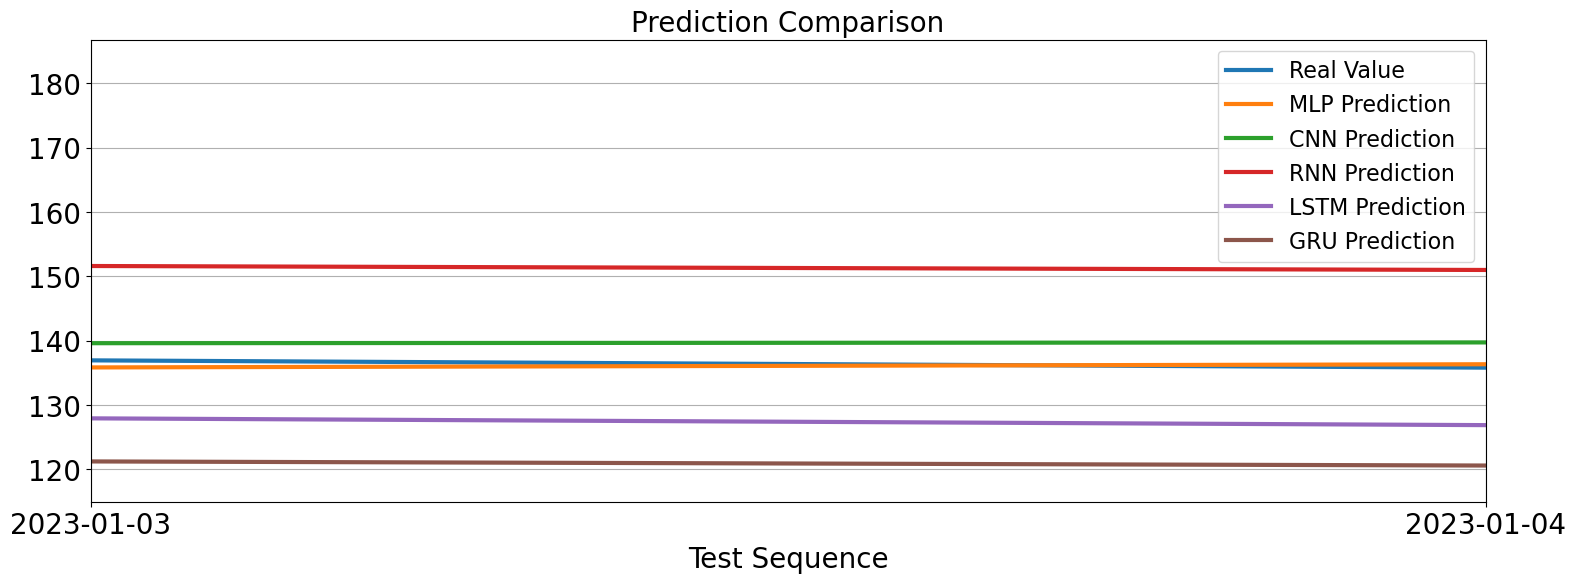

In [66]:
# 저장 모델 불러오기
modelnames = ['MLP', 'CNN', 'RNN', 'LSTM', 'GRU']

# 결과 정리
Y_pred, Score_final = Y_test.copy(), pd.DataFrame()
for each in modelnames:
    FILENAME = os.path.join(os.getcwd(), 'Model', 'apple_'+each+'.h5')
    
    # 베스트 모델 로딩
    model = load_model(FILENAME)
    
    ## 예측하기
    if each in ['MLP', 'CNN']:
        print(each)
        Y_tepred = pd.DataFrame(model.predict(X_teprep2D), 
                                index=Y_teprep2D.index, columns=['Pred'])
        
        # 분석 검증
        Score_nn_early = evaluation_reg(Y_teprep2D, Y_tepred)
        
        # 결과 붙이기
        Y_pred = pd.concat([Y_pred, Y_tepred], axis=1)
        Score_final = pd.concat([Score_final, Score_nn_early.iloc[[0],:]], axis=0)
    else:
        Y_tepred = pd.DataFrame(model.predict(X_teprep3D), 
                                index=Y_teprep3D.index, columns=['Pred'])
        
        # 분석 검증
        Score_nn_early = evaluation_reg(Y_teprep3D, Y_tepred)
        
        # 결과 붙이기
        Y_pred = pd.concat([Y_pred, Y_tepred], axis=1)
        Score_final = pd.concat([Score_final, Score_nn_early.iloc[[0],:]], axis=0)
  
# 정리
Y_pred.columns = ['Real Value']+[i+' Prediction' for i in modelnames]
Score_final.index = modelnames
    
# 결과 출력
display(Score_final)
Y_pred.plot(kind='line', figsize=(18,6), linewidth=3, fontsize=20,
            xlim=(Y_pred.index.min(),Y_pred.index.max()))
plt.title('Prediction Comparison', fontsize=20)
plt.xlabel('Test Sequence', fontsize=20)
plt.ylabel('', fontsize=20)
plt.legend(fontsize=16)
plt.grid()
plt.show()